# Ejercicio de Optimización: **Pompa de jabón**

Trabajo realizado por el **Grupo 1**

- Landolfi Cano, Silvia

- López Gallo, Ismael

- López García, Álvaro

- Rodríguez de Frutos, Pablo

## Introducción

En este documento se presenta el problema de optimización sobre el caso de una pompa de jabón apoyada entre dos circunferencias paralelas y coaxiales, como se puede ver en la siguiente imagen:

<img src=https://www.soapbubble.dk/content/2-artikler/5-former/dsc_1540.jpg alt="Pompa de jabón apoyada entre dos circunferencias paralelas y coaxiales" height="500">

<figcaption>Figura 1. Pompa de jabón apoyada entre dos circunferencias paralelas y coaxiales</figcaption>

En la forma de equilibrio que adopta la superficie libre de este fluido es aquella que minimiza la energía total del sistema para el caso con las restricciones que se tengan. En esta energía, se han de tomar en consideración, energías como pueden ser:

- La energía debida a la **tensión superficial**, proporcional al área. 

- La **energía potencial**, debida a la gravedad y/o a la rotación como sólido rígido. 

Este problema presenta una solución analítica para uno de los problemas más sencillos: la **catenoide**.

Suponiendo una superficie axilsimétrica, con un radio dado por $\rho=F(z)$, la energía superficial es proporcional (siendo la constante de proporcionalidad la energía por unidad de área) a la superficie, siendo esta proporcional (una vez adimensionalizada adecuadamente) a:

$A = \int_0^1 F \sqrt{1 + \left( \frac{dF}{dz} \right)^2} dz$

Donde se ha escogido la adimensionalización para que la distancia entre las superficies sea la unidad. 

## Planteamiento del problema

En primer lugar, se van a importar las bibliotecas necesarias para el cálculo del problema. Algunas de las más relevantes son:

- [`numpy`](https://numpy.org/): principal librería de Python que permite trabajar con arrays e incluye funciones de alto nivel para operar con ellos.

- [`scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.htmlº): que proporciona los algoritmos de optimización empleados para el problema de estudio. 

- [`matplotlib`](https://matplotlib.org/): empleada para representar gráficamente los resultados.

- [`time`](https://docs.python.org/3/library/time.html): para calcular el tiempo empleado en correr los fragmentos de código.

- [`pygad`](https://pygad.readthedocs.io/en/latest): soporte para implementar algorimos genéticos de optimización.

- [`pyswarms`](https://pyswarms.readthedocs.io/en/latest/): desarrollada por el MIT para implementar el algoritmo de optimización *Particle Swarm*.

- [`simanneal`](https://github.com/perrygeo/simanneal/tree/master): permite la implementación del algoritmo de optimización *Simulated Annealing*.

In [1]:
import numpy as np
import autograd.numpy as anp
from scipy.optimize import minimize, fsolve, differential_evolution, NonlinearConstraint
import matplotlib.pyplot as plt
import time
import pygad
import pyswarms as ps
from simanneal import Annealer
import seaborn as sns

2024-06-05 11:37:26,508 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [2]:
# Configuración global de Matplotlib
plt.rcParams.update({
    'text.usetex': True,  # Usar LaTeX para el texto
    'font.family': 'serif',  # Fuente serif
    # 'figure.figsize': (10, 6),  # Tamaño de la figura
    'axes.labelsize': 12,  # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Tamaño del título
    'legend.fontsize': 12,  # Tamaño de la leyenda
    'xtick.labelsize': 10,  # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Tamaño de las etiquetas del eje y
    'axes.grid': True,  # Habilitar la cuadrícula
    'grid.alpha': 0.75,  # Transparencia de la cuadrícula
    'grid.linestyle': '--'  # Estilo de la línea de la cuadrícula
})

# Configuración de Seaborn
sns.set_context('paper')
sns.set_style('whitegrid')

### Problema numérico de optimización

A continuación, se define el funcional que se busca minimizar. En el caso del problema que se está considerando, se trata de la superficie del fluido entre ambos soportes, cuya expresión se desarrolla en la introducción.

In [3]:
def area_func(F):
    Famp = anp.append(anp.array([F0]), anp.append(F, F1))
    n = anp.size(Famp)
    delta_z = 1 / (n - 1)

    integral = 0
    for i in range(n-1):
        # calcular la derivada
        F_der = (Famp[i+1] - Famp[i]) / delta_z # esquema adelantado para el cálculo de la derivada
        # calcular el valor de la integral
        integrando = Famp[i] * anp.sqrt(1 + F_der**2)
        integral += integrando * delta_z

    return integral

Se plantea la condición de contorno para el caso en el que ambas circunferencias sean de igual radio, que resulta ser:

$F(z=0) = F(z=1) = F_0$

Para el primer estudio, se escoge arbitrariamente $F_0 = 1$. Más adelante, se estudiará cómo afecta la variación de este parámetro al cálculo de la solución.

In [4]:
F_0 = 1 
F0 = F_0
F1 = F_0

En una primera aproximación, se estudiará para una partición equiespaciada y con un número $n$ arbitrario de puntos.

El valor `F_init` (vector de valores que arranca la iteración) se inicializa para el caso en el que $ F(z) = F_0 , \forall z \in [0, 1]$, es decir, en la posición en la que la superficie formaría un cilindro recto entre ambos soportes. 

Además del sentido físico que pueda tener considerar cómo evoluciona la pompa desde una posición próxima a la de equilibrio, interesa imponer estos valores de arranque por la proximidad de la solución a estos valores del radio, especialmente en las proximidades de los soportes. 

Posteriormente se comentará el efecto de estas condiciones de arranque a la solución del problema.

In [5]:
n = 20
F_init = np.empty(n-2)
F_init.fill(F_0) 

### Solución analítica del problema físico

Volviendo a problema físico, este tiene una solución analítica que, en el caso 2D, toma la forma de una catenaria. Esta es aplicable al problema sin restricciones de volumen, por lo que se va a emplear para comparar las soluciones numéricas obtenidas. 

Así, esta curva sigue la siguiente ecuación:

$F(z) = a \cosh(\frac{z + k}{a})$

Donde $h$, $a$ y $k$ son parámetros que dependen del problema que se esté considerando, por lo que habrá que resolverlos cada vezque se modifiquen las condiciones del problema. Solo por considerar el intervalo $z \in [0, 1]$, se fija el parámetro $h = 0.5$, al ser este el punto medio del intervalo. 

A continuación se plantea como ejemplo el caso más sencillo, que es el que se empleará en la mayoría de análisis a lo largo del trabajo.

In [6]:
eps = 0 # soportes iguales
def params_catenaria(params, eps=eps):
    a, k = params
    eq1 = F0 - a * np.cosh(k / a) 
    eq2 = F1 - a * np.cosh( (1 + k) / a) 
    return [eq1, eq2]

initial_guess = [1.0, 0.0]

a_sol, k_sol = fsolve(params_catenaria, initial_guess)

z = np.linspace(0, 1, n)

def catenaria(z):
    return a_sol * np.cosh((z + k_sol) / a_sol)

F_cat = catenaria(z)

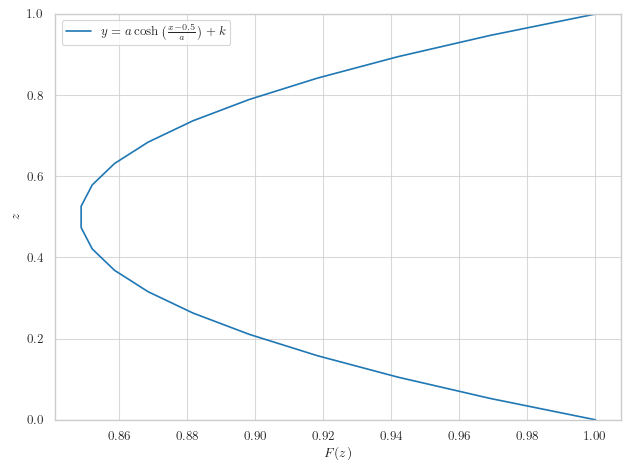

In [7]:
plt.figure()
plt.plot(F_cat, z, label=r'$y = a \cosh\left(\frac{x - 0.5}{a}\right) + k$')
# plt.title('Catenaria en el caso de $F(0) = F(1) = F_0 = 1$')
plt.xlabel('$F(z)$')
plt.ylabel('$z$')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()  # Ajustar el layout para que no se solapen los elementos
plt.savefig('Figuras/catenaria.pdf', format='pdf')
plt.show()

## Problema sin restricciones, con soportes iguales.

Pese a que inicialmente se considere un problema sin restricciones adicionales, no se puede ignorar el sentido físico del funcional que se quiere optimizar: el radio o distancia del eje a la superficie libre del fluído, magnitud que, por definición, es siempre positiva. Así, se impone esta frontera en el primer cálculo de la solución del problema.

In [8]:
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T

### Minimización con un método basado en gradiente

En primer lugar, dentro de los método de tipo gradiente, se considerará el método de [*Sequential Least Squares Programming*](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp). La explicación del método de desarrollará más adelante en el apartado dedicado a ver la influencia de los métodos de optimización en el resultado del problema.

Para más información sobre las librerías empleadas para el cálculo con algoritmos de optimización de tipo gradiente, esta se puede consultar en [este enlace](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

In [9]:
time_start = time.time()
sol_grad = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
time_end = time.time()

time_grad = time_end - time_start
sol_grad

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.9537487850868308
       x: [ 9.697e-01  9.429e-01 ...  9.408e-01  9.684e-01]
     nit: 21
     jac: [-3.795e-04  4.508e-04 ... -3.908e-04  1.709e-04]
    nfev: 429
    njev: 21

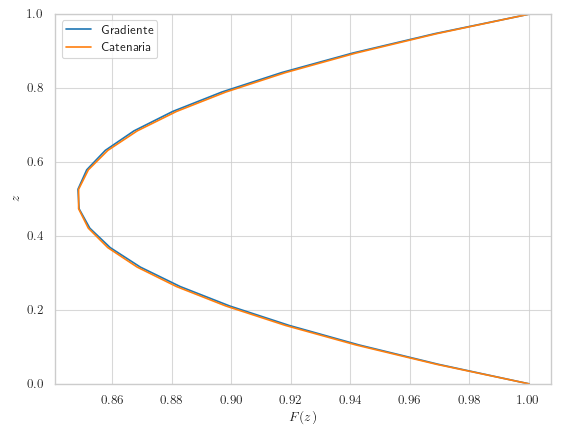

In [10]:
Famp = np.concatenate(([F0], sol_grad.x, [F1]))

F_cat = catenaria(z)

# Crear la gráfica
plt.figure()
plt.plot(Famp, z, label='Gradiente')
plt.plot(F_cat, z, label='Catenaria')
plt.ylabel('$z$')
plt.xlabel('$F(z)$')
plt.legend()
plt.ylim(0, 1)
# plt.xlim(0, 1)
# plt.title('Comparación de la solución de gradiente y la catenaria')
plt.savefig('Figuras/comp_grad_cat.pdf', format='pdf')
plt.grid(True)
plt.show()

A partir de la norma cuadrática de la diferencia entre la solución analítica y la solución calculada se va a calcular el error de la solución. Así, se va a tomar a partir de ahora el siguiente valor de error como referencia para los apartados siguientes. Por tanto, se va a considerar que una aproximación con un error del orden del siguiente es aceptable.

In [11]:
error = np.linalg.norm(Famp - F_cat)/np.linalg.norm(F_cat)
print('El error cuadrático medio de la aproximación es:', error)
print('Tiempo de ejecución:', time_end - time_start)

El error cuadrático medio de la aproximación es: 0.0010218191336893907
Tiempo de ejecución: 0.3036081790924072


#### Influencia del radio, $F_0$.

En este apartado se va a considerar la variación del radio de los dos soportes, $F_0$, bajo la condición de que se mantenga igual en ambos, es decir, manteniendo $F(0) = F(1) = F_0$. Por otro lado, se congelan el resto de parámetros, manteniéndose igual que en el primer estudio.

- $F_0 = 1$

In [12]:
F_0 = 1 
F0 = F_0
F1 = F_0
F_init.fill(F_0)

a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f1 = catenaria(z)

sol_gradf1 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Fampf1 = np.concatenate(([F0], sol_gradf1.x, [F1]))

error_f1 = np.linalg.norm(Fampf1 - cat_f1)/np.linalg.norm(cat_f1)
print('El error para F_0=1 es:', error_f1)

El error para F_0=1 es: 0.0010218191336893907


- $F_0 = 2$

In [13]:
F_0 = 2
F0 = F_0
F1 = F_0
F_init.fill(F_0)

a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f2 = catenaria(z)

sol_gradf2 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Fampf2 = np.concatenate(([F0], sol_gradf2.x, [F1]))

error_f2 = np.linalg.norm(Fampf2 - cat_f2)/np.linalg.norm(cat_f2)
print('El error para F_0=2 es:', error_f2)

El error para F_0=2 es: 5.469805073531967e-05


- $F_0 = 5$

In [14]:
F_0 = 5
F0 = F_0
F1 = F_0
F_init.fill(F_0)

a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f5 = catenaria(z)

sol_gradf5 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Fampf5 = np.concatenate(([F0], sol_gradf5.x, [F1]))

error_f5 = np.linalg.norm(Fampf5 - cat_f5)/np.linalg.norm(cat_f5)
print('El error para F_0=5 es:', error_f5)

El error para F_0=5 es: 0.0001418895570642418


- $F_0 = 0.8$

In [15]:
F_0 = 0.8
F0 = F_0
F1 = F_0
F_init.fill(F_0)

a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f08 = catenaria(z)

sol_gradf08 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Fampf08 = np.concatenate(([F0], sol_gradf08.x, [F1]))

error_f08 = np.linalg.norm(Fampf08 - cat_f08)/np.linalg.norm(cat_f08)
print('El error para F_0=0.8 es:', error_f08)

El error para F_0=0.8 es: 0.006038139196062663


- $F_0 = 0.7$

In [16]:
F_0 = 0.7
F0 = F_0
F1 = F_0
F_init.fill(F_0)

a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f07 = catenaria(z)

sol_gradf07 = minimize(area_func, F_init, bounds=bounds, method='SLSQP') # SLSQP no converge -> COBYLA
Fampf07 = np.concatenate(([F0], sol_gradf07.x, [F1]))

error_f07 = np.linalg.norm(Fampf07 - cat_f07)/np.linalg.norm(cat_f07)
print('El error para F_0=0.7 es:', error_f07)

C:\Users\ismag\AppData\Local\Temp\ipykernel_14892\2021984694.py:6: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a_sol, k_sol = fsolve(params_catenaria, initial_guess)


El error para F_0=0.7 es: 0.6003927362443426


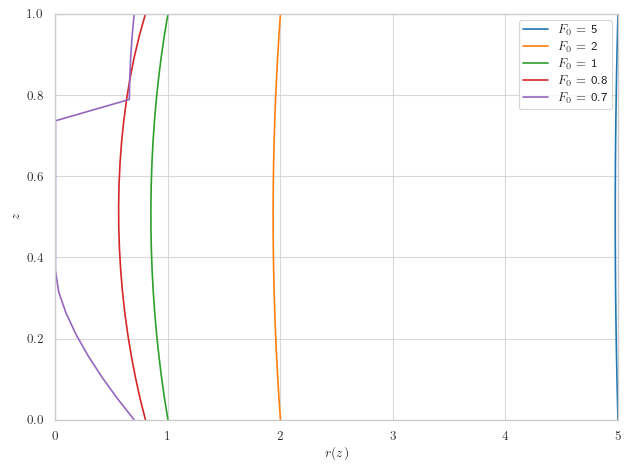

In [17]:
plt.figure()
plt.plot(Fampf5, z, label='$F_0$ = 5')
plt.plot(Fampf2, z, label='$F_0$ = 2')
plt.plot(Fampf1, z, label='$F_0$ = 1')
plt.plot(Fampf08, z, label='$F_0$ = 0.8')
plt.plot(Fampf07, z, label='$F_0$ = 0.7')
# plt.plot(Fampf06, z, label='$F_0$ = 0.6')
plt.legend()
# plt.xscale('log')
plt.ylabel('$z$')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
plt.xlim(0, 5)
# plt.title('Soluciones para distintos valores de $F_0$')
plt.tight_layout()  # Ajustar el layout para que no se solapen los elementos
plt.savefig('Figuras/sol_radios.pdf', format='pdf')
plt.show()

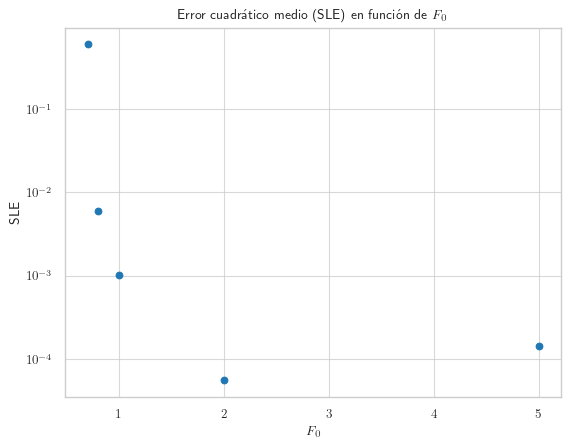

In [18]:
error_grad_radio = [error_f5, error_f2, error_f1, error_f08, error_f07]

plt.scatter([5, 2, 1, 0.8, 0.7], [error_f5, error_f2, error_f1, error_f08, error_f07])
# plt.xscale('log')
plt.yscale('log')
plt.ylabel('SLE')
plt.xlabel('$F_0$')
plt.title('Error cuadrático medio (SLE) en función de $F_0$')
plt.grid(True)

Como se observa en la representación gráfica de estas soluciones, todas en las que aumenta el valor de $F_0$ respecto de la unidad, presentan soluciones similares en cuanto a que se trata de una catenoide ajustada a esos puntos en el inicio y el final del intervalo.

Por otro lado, en los casos en los que $F_0$ decrece, se presenta un comportamiento anómalo. En valores mayores que $F_0 \approx 0.7$ no se produce ningún cambio de tendencia respecto a lo observado anteriormente. Sin embargo, para condiciones de contorno con radios menores o iguales que ese, la solución calculada presenta un comportamiento que puede dar lugar a pensar que se produce por una falta de precisión del algoritmo de optimización, una necesitad de más puntos u otros problemas derivados de la aplicación numérica de los algoritmos de optimización. 

#### Influencia del número de puntos de la discretización.

A continuación, se tratará cómo afecta el número de puntos $n$ en los que se discretiza el intervalo $[0, 1]$, tomando para todos ellos el mismo esquema de partición equiespaciada y manteniendo el mismo valor de las condiciones de contorno y el resto de características del proceso.

In [19]:
# Recuperamos los valores de F_0
F_0 = 1
F0 = F_0
F1 = F_0

- $n = 5$

In [20]:
n = 5
z5 = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f5 = catenaria(z5)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
time_start = time.time()
sol_gradn5 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
time_end = time.time()
time_n5 = time_end - time_start
print('Tiempo de ejecución para n=5:', time_n5)
Fampn5 = np.concatenate(([F0], sol_gradn5.x, [F1]))
error_n5 = np.linalg.norm(Fampn5 - cat_f5)/np.linalg.norm(cat_f5)
print('El error para n=5 es:', error_n5)

Tiempo de ejecución para n=5: 0.04053449630737305
El error para n=5 es: 0.0037659102469243745


- $n = 10$

In [21]:
n = 10
z10 = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f10 = catenaria(z10)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
time_start = time.time()
sol_gradn10 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
time_end = time.time()
time_n10 = time_end - time_start
print('Tiempo de ejecución para n=10:', time_n10)
Fampn10 = np.concatenate(([F0], sol_gradn10.x, [F1]))
error_n10 = np.linalg.norm(Fampn10 - cat_f10)/np.linalg.norm(cat_f10)
print('El error para n=10 es:', error_n10)

Tiempo de ejecución para n=10: 0.05224776268005371
El error para n=10 es: 0.0019433253695356292


- $n = 20$

In [22]:
n = 20
z20 = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f20 = catenaria(z20)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
time_start = time.time()
sol_gradn20 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
time_end = time.time()
time_n20 = time_end - time_start
print('Tiempo de ejecución para n=20:', time_n20)
Fampn20 = np.concatenate(([F0], sol_gradn20.x, [F1]))
error_n20 = np.linalg.norm(Fampn20 - cat_f20)/np.linalg.norm(cat_f20)
print('El error para n=20 es:', error_n20)

Tiempo de ejecución para n=20: 0.15505170822143555
El error para n=20 es: 0.0010218191336893907


- $n = 50$

In [23]:
n = 50
z50 = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f50 = catenaria(z50)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
time_start = time.time()
sol_gradn50 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
time_end = time.time()
time_n50 = time_end - time_start
print('Tiempo de ejecución para n=50:', time_n50)
Fampn50 = np.concatenate(([F0], sol_gradn50.x, [F1]))
error_n50 = np.linalg.norm(Fampn50 - cat_f50)/np.linalg.norm(cat_f50)
print('El error para n=50 es:', error_n50)

Tiempo de ejecución para n=50: 1.0883088111877441
El error para n=50 es: 0.0006467242476269547


- $n = 100$

In [24]:
n = 100
z100 = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f100 = catenaria(z100)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
time_start = time.time()
sol_gradn100 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
time_end = time.time()
time_n100 = time_end - time_start
print('Tiempo de ejecución para n=100:', time_n100)
Fampn100 = np.concatenate(([F0], sol_gradn100.x, [F1]))
error_n100 = np.linalg.norm(Fampn100 - cat_f100)/np.linalg.norm(cat_f100)
print('El error para n=100 es:', error_n100)

Tiempo de ejecución para n=100: 5.163095712661743
El error para n=100 es: 0.0003386263379216046


- $n = 200$

In [25]:
n = 200
z200 = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f200 = catenaria(z200)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
time_start = time.time()
sol_gradn200 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
time_end = time.time()
time_n200 = time_end - time_start
print('Tiempo de ejecución para n=200:', time_n200)
Fampn200 = np.concatenate(([F0], sol_gradn200.x, [F1]))
error_n200 = np.linalg.norm(Fampn200 - cat_f200)/np.linalg.norm(cat_f200)
print('El error para n=200 es:', error_n200)

Tiempo de ejecución para n=200: 26.61276602745056
El error para n=200 es: 0.0013070462813833572


- $n = 400$

In [26]:
n = 400
z400 = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
cat_f400 = catenaria(z400)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
time_start = time.time()
sol_gradn400 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
time_end = time.time()
time_n400 = time_end - time_start
print('Tiempo de ejecución para n=400:', time_n400)
Fampn400 = np.concatenate(([F0], sol_gradn400.x, [F1]))
error_n400 = np.linalg.norm(Fampn400 - cat_f400)/np.linalg.norm(cat_f400)
print('El error para n=400 es:', error_n400)

Tiempo de ejecución para n=400: 104.48518872261047
El error para n=400 es: 0.02872582898714192


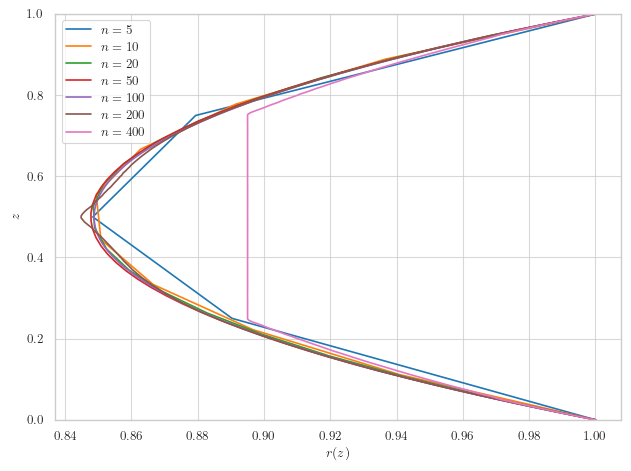

In [27]:
plt.figure()
plt.plot(Fampn5, z5, label='$n = 5$')
plt.plot(Fampn10, z10, label='$n = 10$')
plt.plot(Fampn20, z20, label='$n = 20$')
plt.plot(Fampn50, z50, label='$n = 50$')
plt.plot(Fampn100, z100, label='$n = 100$')
plt.plot(Fampn200, z200, label='$n = 200$')
plt.plot(Fampn400, z400, label='$n = 400$')
plt.legend()
plt.ylabel('$z$')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
# plt.xlim(0, 1)
# plt.title('Soluciones para distintos valores de $n$')
plt.tight_layout()  # Ajustar el layout para que no se solapen los elementos
plt.savefig('Figuras/sol_n.pdf', format='pdf')
plt.show()

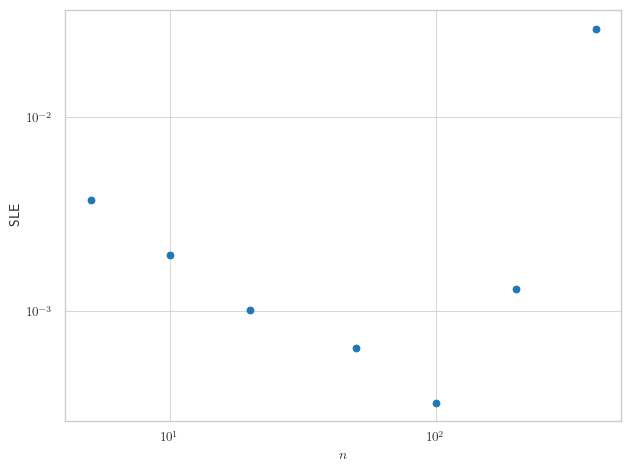

In [28]:
error_grad_n = np.array([error_n5, error_n10, error_n20, error_n50, error_n100, error_n200, error_n400])

plt.figure()
plt.scatter([5, 10, 20, 50, 100, 200, 400], error_grad_n)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('SLE')
plt.xlabel('$n$')
# plt.title('Error en función de n')
plt.tight_layout()  # Ajustar el layout para que no se solapen los elementos
plt.savefig('Figuras/error_n.pdf', format='pdf')
plt.show()

A raíz de esta imagen, se pueden analizar los datos dividiéndolos en tres tendencias de comportamiento distintas y que se van a comentar a continuación por separado.

1. **Pocos puntos** (5 o 10 en la imagen): En estas curvas se aprecia el error del cálculo de la solución por el método empleado para el cálculo de la derivada. Este método presenta un error de truncamiento proporcional al tamaño del intervalo escogido entre puntos, y este es mayor cuantos menos puntos se escojan para aproximar la función. 

2. **Cantidad moderada de puntos** (entre 20 y 100 en la imagen): Estos esquemas son los que mejor se ajustan a la solución. Apenas se pueden apreciar cambios entre las curvas trazadas para dichos valores, por lo que se considera un valor de compromiso intermedio a fin de tener suficiente margen en la estabilidad de la solución.

3. **Excesiva cantidad de puntos** (200, 400 o más): En este caso, los errores que se muestran son causa de la aproximación numérica de la derivada, pero esta vez asociada al error de redondeo. Este es el error asociado a la precisión finita del ordenador, proporcional a la constante de Lebesgue $\Lambda_N$, que, en el caso de una malla equiespaciada, es 
$\Lambda_N \geq \frac{2^N \sqrt{2}}{\pi N (N - 1)}$, donde $N$ es el número de puntos en los que se divide el intervalo. 
Es fácil observar que dicha constante puede alcanzar un valor muy alto incluso para valores moderados de $N$. En el caso que se considera de 200 puntos, la cota inferior es $\Lambda_N \geq 1.8175e+55$, que,  aunque se multiplique por el valor de la precisión numérica de Python (del orden de $10^{-16}$), genera unas cotas de error para nada despreciables, pudiendo acarrear errores en la solución como los observados en la gráfica.

#### Influencia de la distribución de puntos.

En este caso, se va a considerar el efecto de considerar diferentes distribuciones de puntos en las que dividir el intervalo del problema. 

Una vez más, se consideran el resto de parámetros idénticos al primer caso de estudio, salvo por el número de puntos $n$, que se va a modificar a fin de apreciar el comportamiento de distintas distribuciones de puntos en los casos más exigentes, es decir, en los casos extremos de $n$ muy grande o muy pequeño. El caso de $n$ intermedio se omite por presentar soluciones casi idénticas en todos los casos.

##### Caso de $n$ razonablemente pequeño.

In [8]:
n = 10
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T

# planteamos la función que calcula el área tomando delta_z como un array definido anteriormente
def area_distrib(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)

    integral = 0
    for i in range(n-1):
        # calcular la derivada
        F_der = (Famp[i+1] - Famp[i]) / delta_z[i] # esquema adelantado para el cálculo de la derivada
        # calcular el valor de la integral
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z[i]

    return integral

- Distribución de puntos **equiespaciada**

In [9]:
zeq = np.linspace(0, 1, n)
delta_z = np.diff(zeq)
sol_gradeq = minimize(area_distrib, F_init, bounds=bounds, method='SLSQP')
Famp_eq = np.concatenate(([F0], sol_gradeq.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_cateq = catenaria(zeq)
error_eq = np.linalg.norm(Famp_eq - F_cateq)/np.linalg.norm(F_cateq)
print('El error para distribución equiespaciada es:', error_eq)

El error para distribución equiespaciada es: 0.0019433254436008404


- Distribución de puntos según un esquema de **ceros de Chebyshev**: $z_i = \cos{ \left( \frac{\frac{\pi}{2} + \pi i}{n + 1} \right) }, \quad i = 0, \dots , n$

In [10]:
def chebyshev_zeros(a, b, n):
    cheb_zeros = np.cos((2 * np.arange(1, n+1) - 1) * np.pi / (2 * n))
    mapped_zeros = 0.5 * (b - a) * (cheb_zeros + 1) + a
    sorted_zeros = np.sort(mapped_zeros) # porque los calcula en orden decreciente
    return sorted_zeros

zchebz = chebyshev_zeros(0, 1, n)
delta_z = np.diff(zchebz)
sol_gradchebz = minimize(area_distrib, F_init, bounds=bounds, method='SLSQP')
Famp_chebz = np.concatenate(([F0], sol_gradchebz.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catchebz = catenaria(zchebz)
error_chebz = np.linalg.norm(Famp_chebz - F_catchebz)/np.linalg.norm(F_catchebz)
print('El error para los nodos de Chebyshev es:', error_chebz)

El error para los nodos de Chebyshev es: 0.005537720056351027


- Distribución de puntos según un esquema de **extremos de Chebyshev**: $z_i =  \cos{ \left( \frac{\pi i}{n} \right) }, \quad i = 0, \dots , n$

In [11]:
def chebyshev_extremes(a, b, n):
    cheb_extremes = np.cos(np.arange(n) * np.pi / (n - 1))
    mapped_extremes = 0.5 * (b - a) * (cheb_extremes + 1) + a
    sorted_extremes = np.sort(mapped_extremes)
    return sorted_extremes

zchebe = chebyshev_extremes(0, 1, n)
delta_z = np.diff(zchebe)
sol_gradchebe = minimize(area_distrib, F_init, bounds=bounds, method='SLSQP')
Famp_chebe = np.concatenate(([F0], sol_gradchebe.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catchebe = catenaria(zchebe)
error_chebe = np.linalg.norm(Famp_chebe - F_catchebe)/np.linalg.norm(F_catchebe)
print('El error para los extremos de Chebyshev es:', error_chebe)

El error para los extremos de Chebyshev es: 0.0031665998435380046


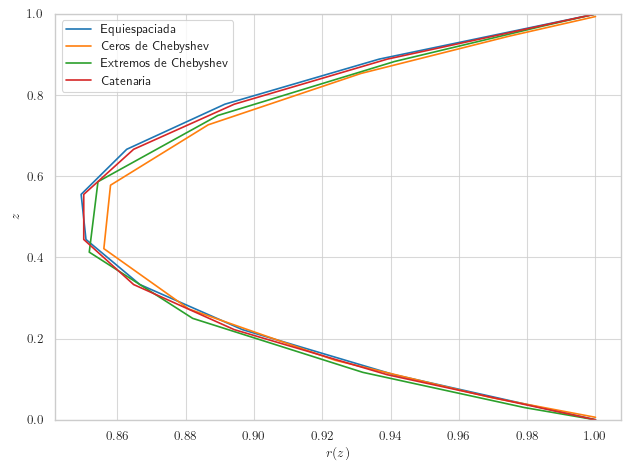

In [12]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(F_cateq, zeq, label='Catenaria')
plt.ylabel('$z$')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
# plt.xlim(0.8, 1)
# puede ser que distribución concentrada en el centro no mejore porque en realidad no hay tanta variación, solo es la escala????
# plt.xlim(0, 1) 
# plt.title('Soluciones para distintas distribuciones de puntos, con $n = {}$'.format(n))
plt.legend()
plt.tight_layout()
plt.savefig('Figuras/sol_distrib_n10.pdf', format='pdf')    
plt.show()

En el caso expuesto, se aprecia una solución que, aunque en los extremos del intervalo se parece mucho, no así en la parte central. Esto es debido a que las distribuciones no equiespaciadas acumulan mayor cantidad de puntos en los extremos del intervalo mientras que, en el centro de este, el espaciado entre ellos es mayor, provocando así que la aproximación de la solución sea más imprecisa, por el mismo motivo que se comentó sobre la influencia del número de puntos anteriormente.

##### Caso de $n$ muy grande.

In [34]:
n = 200
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T

# planteamos la función que calcula el área tomando delta_z como un array definido anteriormente
def area_distrib(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)
    # delta_z = 1 / (n - 1)

    integral = 0
    for i in range(n-1):
        # calcular la derivada
        F_der = (Famp[i+1] - Famp[i]) / delta_z[i] # esquema adelantado para el cálculo de la derivada
        # calcular el valor de la integral
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z[i]

    return integral

- Distribución de puntos **equiespaciada**

In [35]:
zeq = np.linspace(0, 1, n)
delta_z = np.diff(zeq)
sol_gradeq = minimize(area_distrib, F_init, bounds=bounds, method='SLSQP')
Famp_eq = np.concatenate(([F0], sol_gradeq.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_cateq = catenaria(zeq)
error_eq = np.linalg.norm(Famp_eq - F_cateq)
print('El error para distribución equiespaciada es:', error_eq)

El error para distribución equiespaciada es: 0.01807891226018332


- Distribución de puntos según un esquema de **ceros de Chebyshev**

In [36]:
def chebyshev_zeros(a, b, n):
    cheb_zeros = np.cos((2 * np.arange(1, n+1) - 1) * np.pi / (2 * n))
    mapped_zeros = 0.5 * (b - a) * (cheb_zeros + 1) + a
    sorted_zeros = np.sort(mapped_zeros) # porque los calcula en orden decreciente
    return sorted_zeros

zchebz = chebyshev_zeros(0, 1, n)
delta_z = np.diff(zchebz)
sol_gradchebz = minimize(area_distrib, F_init, bounds=bounds, method='SLSQP')
Famp_chebz = np.concatenate(([F0], sol_gradchebz.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catchebz = catenaria(zchebz)
error_chebz = np.linalg.norm(Famp_chebz - F_catchebz)
print('El error para los nodos de Chebyshev es:', error_chebz)

El error para los nodos de Chebyshev es: 0.012021660678577325


- Distribución de puntos según un esquema de **extremos de Chebyshev**

In [37]:
def chebyshev_extremes(a, b, n):
    cheb_extremes = np.cos(np.arange(n) * np.pi / (n - 1))
    mapped_extremes = 0.5 * (b - a) * (cheb_extremes + 1) + a
    sorted_extremes = np.sort(mapped_extremes)
    return sorted_extremes

zchebe = chebyshev_extremes(0, 1, n)
delta_z = np.diff(zchebe)
sol_gradchebe = minimize(area_distrib, F_init, bounds=bounds, method='SLSQP')
Famp_chebe = np.concatenate(([F0], sol_gradchebe.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catchebe = catenaria(zchebe)
error_chebe = np.linalg.norm(Famp_chebe - F_catchebe)
print('El error para los extremos de Chebyshev es:', error_chebe)

El error para los extremos de Chebyshev es: 0.006689913533817554


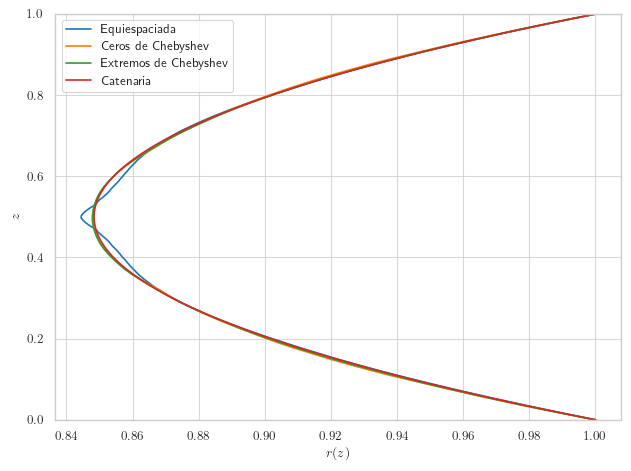

In [38]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(F_cateq, zeq, label='Catenaria')
plt.legend()
plt.ylabel('$z$')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
# plt.xlim(0.8, 1)
# plt.title('Soluciones para distintas distribuciones de puntos, con $n = {}$'.format(n))
plt.tight_layout()
plt.savefig('Figuras/sol_distrib_n200.pdf', format='pdf') 
plt.show()

Al contrario que en el caso anterior, ahora las distribuciones que mejor se comportan son las no equiespaciadas. En este caso se debe a que, como se comentó en el apartado sobre la influencia del número de puntos, las distribuciones equiespaciadas presentan un error de redondeo que se dispara al aumentar el número de puntos, que es lo que ocurre en este caso. 

Por contra, las distribuciones no equiespaciadas acumulan más puntos en los extremos, que es donde se produce un cambio más pronunciado de las propiedades, consiguiendo adaptarse así mejor, y manteniendo una densidad de puntos moderada en los puntos centrales, reduciendo así el error de redondeo.

#### Influencia del esquema de cálculo de derivadas.

En este caso, se pasará a estudiar la influencia del esquema de derivación en la solución obtenida del problema. Los esquemas de diferencias finitas que se consideran para el cálculo se tratan de los más sencillos, que son los estudiados en la asignatura.

Para ello, en primer lugar, se implementa en el código el cálculo de las derivadas por cada uno de los esquemas que se mencionan a continuación.

- Diferencias finitas progresivas: $\frac{\partial F}{\partial z} = \frac{F(z + \delta_z) - F(z)}{\delta_z}$

In [39]:
def area_forw(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)
    delta_z = 1 / (n - 1)

    integral = 0
    for i in range(n-1):
        # calcular la derivada
        F_der = (Famp[i+1] - Famp[i]) / delta_z
        # calcular el valor de la integral
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z

    return integral

- Diferencias finitas regresivas: $\frac{\partial F}{\partial z} = \frac{F(z) - F(z - \delta_z)}{\delta_z}$

In [40]:
def area_back(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)
    delta_z = 1 / (n - 1)

    integral = 0
    for i in range(1, n):
        # calcular la derivada
        F_der = (Famp[i] - Famp[i-1]) / delta_z 
        # calcular el valor de la integral
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z

    return integral

- Diferencias finitas centradas: $\frac{\partial F}{\partial z} = \frac{F(z + \delta_z) - F(z - \delta_z)}{2 \delta_z}$

In [41]:
def area_cent(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)
    delta_z = 1 / (n - 1)

    integral = 0
    for i in range(n):
        if i == 0:  # forward difference at the first point
            F_der = (Famp[i+1] - Famp[i]) / delta_z
        elif i == n-1:  # backward difference at the last point
            F_der = (Famp[i] - Famp[i-1]) / delta_z
        else:  # central difference at interior points
            F_der = (Famp[i+1] - Famp[i-1]) / (2*delta_z)
        
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z

    return integral

- Diferencias finitas de paso complejo: $\frac{\partial F}{\partial z} = \frac{\text{Im}(F(z + i\delta_z))}{\delta_z}$

In [42]:
h = 1e-8

def area_comp(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)
    delta_z = 1 / (n - 1)

    integral = 0
    for i in range(n-1):
        # Perturb the value with a complex step
        F_complex = Famp.copy().astype(complex)
        F_complex[i] += 1j * h
        
        # Compute the derivative using the complex step method
        F_der = np.imag(F_complex[i] / h)
        # print(F_complex[i])
        # print('derivada', F_der)
        
        # Calculate the value of the integral
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z

    return integral.real

A continuación, se va a observar el efecto del esquema de cálculo de la derivada en función del número de puntos escogidos, en todos los casos bajo el mismo esquema de partición del intervalo equiespaciado. 

##### **Para un número bajo de puntos**: $n = 10$.

In [43]:
n = 10
z = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
Fcat = catenaria(z)
error_forw = np.array([])
error_back = np.array([])
error_cent = np.array([])
error_comp = np.array([])

In [44]:
sol_gradforw = minimize(area_forw, F_init, bounds=bounds, method='SLSQP')
Famp_forw = np.concatenate(([F0], sol_gradforw.x, [F1]))
error_forw = np.append(error_forw, np.linalg.norm(Famp_forw - Fcat))
print('El error para forward difference es:', error_forw[-1])

sol_gradback = minimize(area_back, F_init, bounds=bounds, method='SLSQP')
Famp_back = np.concatenate(([F0], sol_gradback.x, [F1]))
error_back = np.append(error_back, np.linalg.norm(Famp_back - Fcat))
print('El error para backward difference es:', error_back[-1])

sol_gradcent = minimize(area_cent, F_init, bounds=bounds, method='SLSQP')
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
error_cent = np.append(error_cent, np.linalg.norm(Famp_cent - Fcat))
print('El error para central difference es:', error_cent[-1])

sol_gradcomp = minimize(area_comp, F_init, bounds=bounds, method='SLSQP')
Famp_comp = np.concatenate(([F0], sol_gradcomp.x, [F1]))
error_comp = np.append(error_comp, np.linalg.norm(Famp_comp - Fcat))
print('El error para complex step es:', error_comp[-1])

El error para forward difference es: 0.005600031297052606
El error para backward difference es: 0.005600029631422671
El error para central difference es: 0.06140265490282978
El error para complex step es: 2.5107863952786564


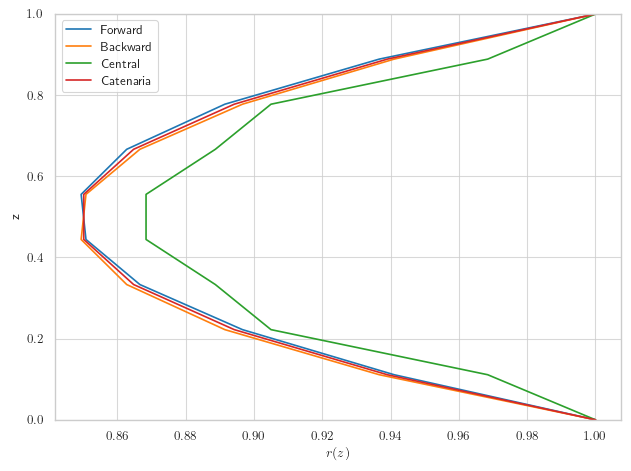

In [45]:
plt.plot(Famp_forw, z, label = 'Forward')
plt.plot(Famp_back, z, label = 'Backward')
plt.plot(Famp_cent, z, label = 'Central')
plt.plot(Fcat, z, label = 'Catenaria')
# plt.plot(Famp_comp, z, label = 'Complex')
plt.legend()
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
# plt.xlim(0, 1)
# plt.title('Influencia del esquema de derivación en la solución, para $n = {}$'.format(n))
plt.tight_layout()
plt.savefig('Figuras/sol_deriv_n10.pdf', format='pdf') 
plt.show()

Antes de nada, cabe reseñar la proximidad de la solución de las diferencias finitas adelantadas y las retrasadas, tendencia que se va a mantener para todos los casos, por lo que, cuando se hable de diferencias finitas descentradas, se hará referencia a ambas en lo que sigue, para evitar repeticiones innecesarias.

En este caso, se puede apreciar como las diferencias finitas descentradas generan un mejor resultado en la aproximación de la solución. Esto es debido a que el paso en la fórmula de las diferencias finitas centradas es el doble que en las otras, por lo que se procuce un cambio más pronunciado en las propiedades en ese espaciado que en las descentradas, acarreando así mayor error en la aproximación de la función. 

##### **Para un número moderado de puntos**: $n = 100$.

In [46]:
n = 100
z = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
Fcat = catenaria(z)

In [47]:
sol_gradforw = minimize(area_forw, F_init, bounds=bounds, method='SLSQP')
Famp_forw = np.concatenate(([F0], sol_gradforw.x, [F1]))
error_forw = np.append(error_forw, np.linalg.norm(Famp_forw - Fcat))
print('El error para forward difference es:', error_forw[-1])

sol_gradback = minimize(area_back, F_init, bounds=bounds, method='SLSQP')
Famp_back = np.concatenate(([F0], sol_gradback.x, [F1]))
error_back = np.append(error_back, np.linalg.norm(Famp_back - Fcat))
print('El error para backward difference es:', error_back[-1])

sol_gradcent = minimize(area_cent, F_init, bounds=bounds, method='SLSQP')
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
error_cent = np.append(error_cent, np.linalg.norm(Famp_cent - Fcat))
print('El error para central difference es:', error_cent[-1])

sol_gradcomp = minimize(area_comp, F_init, bounds=bounds, method='SLSQP')
Famp_comp = np.concatenate(([F0], sol_gradcomp.x, [F1]))
error_comp = np.append(error_comp, np.linalg.norm(Famp_comp - Fcat))
print('El error para complex step es:', error_comp[-1])

El error para forward difference es: 0.003049379653914534
El error para backward difference es: 0.006877680601583818
El error para central difference es: 0.025919439084958595
El error para complex step es: 8.893405235777724


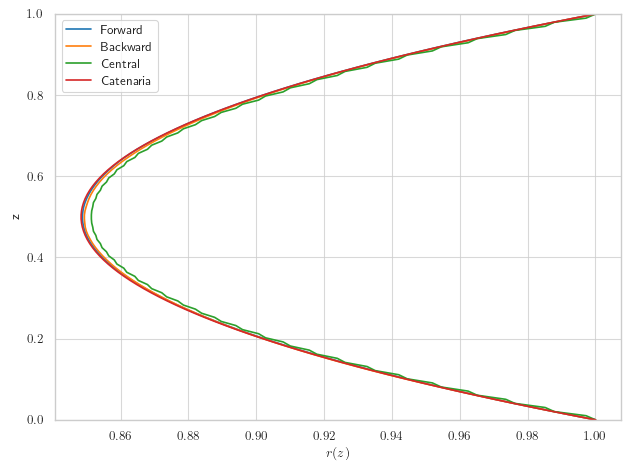

In [48]:
plt.plot(Famp_forw, z, label = 'Forward')
plt.plot(Famp_back, z, label = 'Backward')
plt.plot(Famp_cent, z, label = 'Central')
plt.plot(Fcat, z, label = 'Catenaria')
# plt.plot(Famp_comp, z, label = 'Complex')
plt.legend()
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
# plt.xlim(0, 1)
# plt.title('Influencia del esquema de derivación en la solución, para $n = {}$'.format(n))
plt.tight_layout()
plt.savefig('Figuras/sol_deriv_n100.pdf', format='pdf') 
plt.show()

En el caso de escoger una cantidad moderada de puntos, se observa un comportamiento similar al estudiado en el caso anterior. Sin embargo, en este caso, las diferencias finitas centradas se acercan aún más al resultado de las fórmulas descentradas. Esto se produce porque, al aumentar tanto el espaciado, aunque el paso sea mayor que en el caso de las fórmulas descentradas, presenta una aproximación cada vez más aceptable de la solución.   

##### **Para un número elevado de puntos**: $n = 200$.

In [49]:
n = 200
z = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
Fcat = catenaria(z)

In [50]:
sol_gradforw = minimize(area_forw, F_init, bounds=bounds, method='SLSQP')
Famp_forw = np.concatenate(([F0], sol_gradforw.x, [F1]))
error_forw = np.append(error_forw, np.linalg.norm(Famp_forw - Fcat))
print('El error para forward difference es:', error_forw[-1])

sol_gradback = minimize(area_back, F_init, bounds=bounds, method='SLSQP')
Famp_back = np.concatenate(([F0], sol_gradback.x, [F1]))
error_back = np.append(error_back, np.linalg.norm(Famp_back - Fcat))
print('El error para backward difference es:', error_back[-1])

sol_gradcent = minimize(area_cent, F_init, bounds=bounds, method='SLSQP')
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
error_cent = np.append(error_cent, np.linalg.norm(Famp_cent - Fcat))
print('El error para central difference es:', error_cent[-1])

sol_gradcomp = minimize(area_comp, F_init, bounds=bounds, method='SLSQP')
Famp_comp = np.concatenate(([F0], sol_gradcomp.x, [F1]))
error_comp = np.append(error_comp, np.linalg.norm(Famp_comp - Fcat))
print('El error para complex step es:', error_comp[-1])

El error para forward difference es: 0.016635528865998166
El error para backward difference es: 0.01807696034007079
El error para central difference es: 0.020677694900428326
El error para complex step es: 12.648760871204432


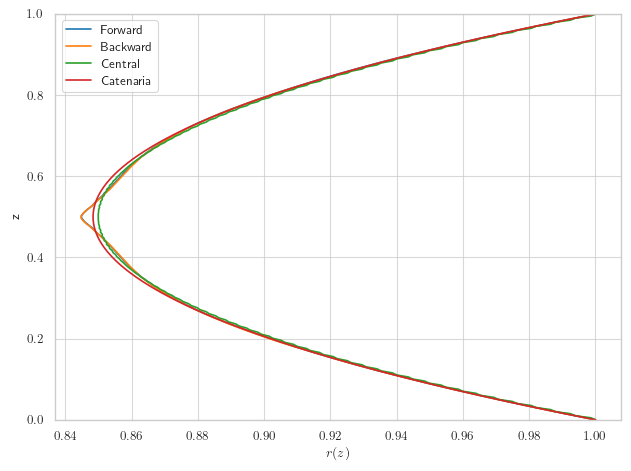

In [51]:
plt.plot(Famp_forw, z, label = 'Forward')
plt.plot(Famp_back, z, label = 'Backward')
plt.plot(Famp_cent, z, label = 'Central')
plt.plot(Fcat, z, label = 'Catenaria')
# plt.plot(Famp_comp, z, label = 'Complex')
plt.legend()
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
# plt.xlim(0, 1)
# plt.title('Influencia del esquema de derivación en la solución, para $n = {}$'.format(n))
plt.tight_layout()
plt.savefig('Figuras/sol_deriv_n200.pdf', format='pdf') 
plt.show()

Al contrario que en los casos estudiados para menor cantidad de puntos, al aumentar lo suficiente $n$ se produce un cambio de tendencia. 

En este caso, ningún esquema que proporciona un gran resultado, aunque el que emplea un cálculo de la derivada siguiendo un esquema de diferencias finitas centradas mantiene más fidelidad con la solución. Precisamente, el cambio respecto a lo considerado anteriormente se debe al mismo motivo por el que antes no se conseguía una aprozimación tan buena: que el paso sea el doble que en las diferencias finitas descentradas. 

Al crecer tanto el error de redondeo (según la constante de Lebesge, $\Lambda$), las diferencias finitas descentradas para una malla equiespaciada dejan de ser una opción viable en cuanto aumenta el número de puntos por encima de un umbral relativamente bajo. Es así que, para mallas con muchos puntos, se recomienda cambiar el esquema a uno de derivadas finitas centradas.

##### **La cantidad de puntos tendiendo a infinito**: $n = 600$.

In [52]:
n = 600
z = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
Fcat = catenaria(z)

In [53]:
sol_gradforw = minimize(area_forw, F_init, bounds=bounds, method='SLSQP')
Famp_forw = np.concatenate(([F0], sol_gradforw.x, [F1]))
error_forw = np.append(error_forw, np.linalg.norm(Famp_forw - Fcat))
print('El error para forward difference es:', error_forw[-1])

sol_gradback = minimize(area_back, F_init, bounds=bounds, method='SLSQP')
Famp_back = np.concatenate(([F0], sol_gradback.x, [F1]))
error_back = np.append(error_back, np.linalg.norm(Famp_back - Fcat))
print('El error para backward difference es:', error_back[-1])

sol_gradcent = minimize(area_cent, F_init, bounds=bounds, method='SLSQP')
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
error_cent = np.append(error_cent, np.linalg.norm(Famp_cent - Fcat))
print('El error para central difference es:', error_cent[-1])

sol_gradcomp = minimize(area_comp, F_init, bounds=bounds, method='SLSQP')
Famp_comp = np.concatenate(([F0], sol_gradcomp.x, [F1]))
error_comp = np.append(error_comp, np.linalg.norm(Famp_comp - Fcat))
print('El error para complex step es:', error_comp[-1])

El error para forward difference es: 1.186650823024162
El error para backward difference es: 1.1866235576945554
El error para central difference es: 0.32935354938310174


KeyboardInterrupt: 

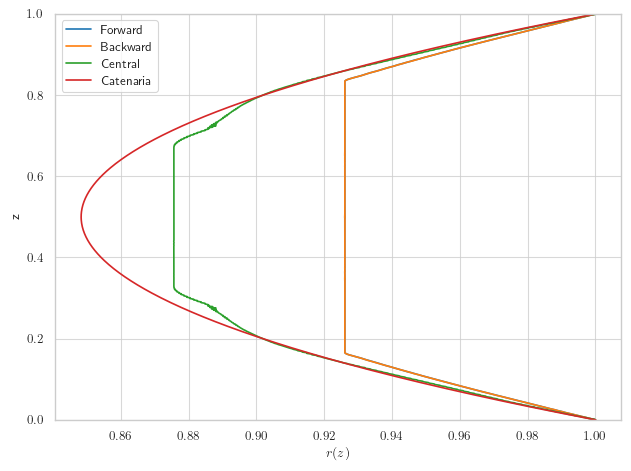

In [ ]:
plt.plot(Famp_forw, z, label = 'Forward')
plt.plot(Famp_back, z, label = 'Backward')
plt.plot(Famp_cent, z, label = 'Central')
plt.plot(Fcat, z, label = 'Catenaria')
# plt.plot(Famp_comp, z, label = 'Complex')
plt.legend()
plt.ylabel('z')
plt.xlabel('$F(z)$')
plt.ylim(0, 1)
# plt.xlim(0, 1)# plt.title('Influencia del esquema de derivación en la solución, para $n = {}$'.format(n))
plt.tight_layout()
plt.savefig('Figuras/sol_deriv_n600.pdf', format='pdf') 
plt.show()

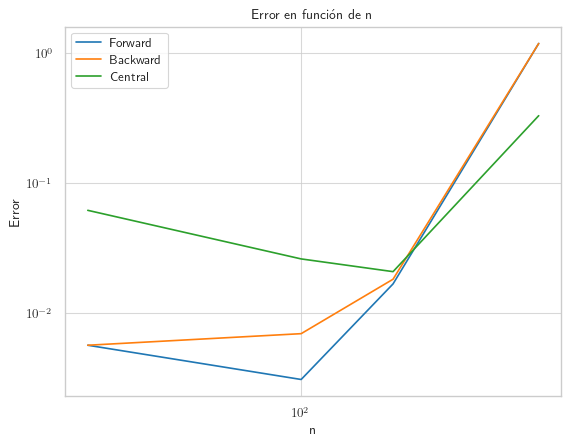

In [ ]:
plt.plot([20, 100, 200, 600], error_forw, label = 'Forward')
plt.plot([20, 100, 200, 600], error_back, label = 'Backward')
plt.plot([20, 100, 200, 600], error_cent, label = 'Central')
# plt.plot([20, 100, 200, 600], error_comp, label = 'Complex')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel('n')
plt.title('Error en función de n')
plt.grid(True)
plt.show()

Aunque en este caso se consideren "tan solo" 600 puntos, es un buen indicador del efecto que tiene aumentar la cantidad de puntos por encima de un límite admisible, o lo que es lo mismo, en el límite de $n \to \infty$. 

Aquí, se observa que sendos esquemas descentrados y centrados sufren errores, una vez más debidos al error de redondeo, a su vez proporcional a la constante de Lebesgue. En este caso, tanto el esquema centrado de cálculo de diferencias finitas como, evidentemente, los esquemas descentrados, presentan amplitudes de los intervalos tan pequeñas entre los puntos que se evalúa la función que el error numérico al dividir por valores tan pequeños se dispara, provocando estas soluciones que para nada se parecen a la solución real del problema.

#### Influencia del algoritmo de optimización. <font color='red'> SEGURAMENTE SEA MEJOR QUITARLO </font>

En este apartado, se van a comentar los efectos de los algoritmos de optimización empleados, especialmente en lo que a eficiencia de iteraciones y tiempo de ejecución se refiere. Para ello, se va a 

Se calculan tanto el gradiente como la hessiana para los métodos que lo requieren:

In [ ]:
from autograd import grad
area_func_grad = grad(area_func)

from autograd import hessian
area_func_hessian = hessian(area_func)

##### Funciones con pocas variables de salida: $n = 20$.

In [ ]:
n = 20 
z = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
Fcat = catenaria(z)

error_CG = np.array([])
error_BFGS = np.array([])
error_Newton_CG = np.array([])
error_LBFGSB = np.array([])
error_SLSQP = np.array([])
error_trustncg = np.array([])
error_cobyla = np.array([])
error_nelder = np.array([])

time_CG = np.array([])
time_BFGS = np.array([])
time_Newton_CG = np.array([])
time_LBFGSB = np.array([])
time_SLSQP = np.array([])
time_trustncg = np.array([])
time_cobyla = np.array([])
time_nelder = np.array([])

1. **Método del *Steepest Descent* (descenso más pronunciado)**

El método del *Steepest Descent* es un algoritmo de optimización que busca minimizar una función objetivo $f(x)$ moviéndose iterativamente en la dirección opuesta al gradiente de la función en el punto actual, ya que le gradiente apunta en la dirección de máximo intemento de la función. Al moverse en la dirección opuesta, se intenta encontrar un punto donde la función tenga un valor mínimo.

Como no se han localizado librerías en las que se encuentre programado el método de *Steepest Descent*, se recoge a continuación el código con el que se ha programado dicho método.

In [ ]:
class SteepestDescent:
    def __init__(self, area_func, x_init, learning_rate=0.01, max_iters=100000, epsilon=1e-6):
        self.area_func = area_func
        self.x_init = x_init
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.x = None
        self.nit = None
        self.message = None
        self.success = None
        self.status = None
        self.fun = None
        self.nfev = None
        # self.maxcv = None

    def run(self):
        x = self.x_init
        for i in range(self.max_iters):
            grad = area_func_grad(x)
            x_new = x - self.learning_rate * grad  # Actualizar x
            if anp.abs(self.area_func(x_new) - self.area_func(x)) < self.epsilon:  # Si la mejora es muy pequeña, detenerse
                self.message = "Optimization terminated successfully."
                self.success = True
                self.status = 0
                self.fun = self.area_func(x_new)
                self.nfev = i+1
                # self.maxcv = 0.0
                break
            x = x_new
            self.nit = i+1
        else:  # Se ejecuta si el bucle for se agota (se alcanza el número máximo de iteraciones)
            self.message = "Maximum number of function evaluations has been exceeded."
            self.success = False
            self.status = 2
            self.fun = self.area_func(x_new)
            self.nfev = self.max_iters
            # self.maxcv = 0.0
        self.x = x

In [ ]:
# time_start = time.time()

# optimizer_steepest = SteepestDescent(area_func, F_init)
# optimizer_steepest.run()

# time_end = time.time()
# time_steepest = time_end - time_start
# Famp_steepest = np.concatenate(([F0], optimizer_steepest.x, [F1]))

In [ ]:
# print(optimizer_steepest.message)
# print('Valor de la función:', optimizer_steepest.fun)
# # print('Resultado:', optimizer_steepest.x)
# print('Evaluaciones de la función:', optimizer_steepest.nfev)
# print('Tiempo de ejecución:', time_steepest)

2. ***Conjugate Gradient* (gradiente conjugado)**.

El método del *Conjugate Gradient* es un algoritmo iterativo que combina las ventajas del *Steepest Descent* y los métodos directos, como la factorización LU, para encontrar soluciones eficientes a problemas de optimización.

A diferencia del *Steepest Descent*, que puede zigzaguear, el método del *Conjugate Gradient* genera una serie de direcciones conjugadas que son ortogonales entre sí respecto a la matriz del problema. Esto permite una convergencia más rápida.

Como ventajas respecto de su eficiencia, no requiere almacenamiento de matrices grandes ni operaciones de factorización costosas, lo que lo hace adecuado para problemas de gran escala.

En la imagen siguiente, se aprecia la comparativa entre el método del <font color='green'>*Steepest Descent*</font> (en verde) y el método del <font color='red'>Gradiente Conjugado</font> (en rojo).

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Conjugate_gradient_illustration.svg/330px-Conjugate_gradient_illustration.svg.png height=400>

In [ ]:
time_start = time.time()

optimizer_CG = minimize(area_func, F_init, method='CG', options={'maxiter': 100000}) # no se pueden imponer restricciones

time_end = time.time()
time_CG = np.append(time_CG, time_end - time_start)
Famp_CG = np.concatenate(([F0], optimizer_CG.x, [F1]))
error_CG = np.append(error_CG, np.linalg.norm(Famp_CG - Fcat))

In [ ]:
print(optimizer_CG.message)
print('Valor de la función:', optimizer_CG.fun)
# print('Resultado:', optimizer_CG.x)
print('Evaluaciones de la función:', optimizer_CG.nfev)
print('Tiempo de ejecución:', time_CG[-1])
print('Evaluaciones del gradiente:', optimizer_CG.njev)
print('El error para el método de Newton-CG es:', error_CG[-1])

Optimization terminated successfully.
Valor de la función: 0.9537486906979558
Evaluaciones de la función: 2318
Tiempo de ejecución: 0.6020419597625732
Evaluaciones del gradiente: 122
El error para el método de Newton-CG es: 0.0038505408710451717


3. **Método de Newton de gradiente conjugado**.

El método de Newton del gradiente conjugado es un algoritmo de optimización que combina los principio del método de Newton y del gradiente conjugado para minimizar funciones. Utiliza la información de la matriz Hessiana para mejorar la dirección de búsqueda y la convergencia en comparación con métodos que utilizan únicamente en la primera derivada.

In [ ]:
time_start = time.time()

optimizer_Newton_CG = minimize(area_func, F_init, method='Newton-CG', jac=area_func_grad, hess=area_func_hessian, options={'maxiter': 100000})

time_end = time.time()
time_Newton_CG = np.append(time_Newton_CG, time_end - time_start)
Famp_Newton_CG = np.concatenate(([F0], optimizer_Newton_CG.x, [F1]))
error_Newton_CG = np.append(error_Newton_CG, np.linalg.norm(Famp_Newton_CG - Fcat))

In [ ]:
print(optimizer_Newton_CG.message)
print('Valor de la función:', optimizer_Newton_CG.fun)
# print('Resultado:', optimizer_Newton_CG.x)
print('Evaluaciones de la función:', optimizer_Newton_CG.nfev)
print('Tiempo de ejecución:', time_Newton_CG[-1])
print('Evaluaciones del gradiente:', optimizer_Newton_CG.njev)
print('El error para el método de Newton-CG es:', error_Newton_CG[-1])

Optimization terminated successfully.
Valor de la función: 0.953748690718871
Evaluaciones de la función: 7
Tiempo de ejecución: 1.1240878105163574
Evaluaciones del gradiente: 7
El error para el método de Newton-CG es: 0.003850769917892317


4. **Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS)** (quasi-Newton).

El algoritmo BFGS es un método cuasi-Newton que actualiza una aproximación de la inversa de la matriz Hessiana utilizando información del gradiente. En vez de calcular la Hessiana completa, el algoritmo utliliza una serie de actualizaciones para aproximar la inversa de dicha matriz, reduciendo significativamente el costo computacional.

Como todos los métodos cuasi-Newton, el BFGS genera una aproximación de la inversa de la Hessiana, en lugar de calcularla directamente. Es uno de los métodos más robustos y con buena tasa de convergencia, por lo que es uno de los métodos más usados en la actualidad.

In [ ]:
time_start = time.time()

optimizer_BFGS = minimize(area_func, F_init, method='BFGS', jac=area_func_grad, options={'maxiter': 100000})

time_end = time.time()
time_BFGS = np.append(time_BFGS, time_end - time_start)
Famp_BFGS = np.concatenate(([F0], optimizer_BFGS.x, [F1]))
error_BFGS = np.append(error_BFGS, np.linalg.norm(Famp_BFGS - Fcat))

In [ ]:
print(optimizer_BFGS.message)
print('Valor de la función:', optimizer_BFGS.fun)
# print('Resultado:', optimizer_BFGS.x)
print('Evaluaciones de la función:', optimizer_BFGS.nfev)
print('Tiempo de ejecución:', time_BFGS[-1])
print('Evaluaciones del gradiente:', optimizer_BFGS.njev)
print('El error para el método de BFGS es:', error_BFGS[-1])

Optimization terminated successfully.
Valor de la función: 0.9537486906273623
Evaluaciones de la función: 28
Tiempo de ejecución: 0.6330444812774658
Evaluaciones del gradiente: 28
El error para el método de BFGS es: 0.003848975593082678


5. ***Limited-memory BFGS with Box constraints* (L-BFGS-B)**.

Este método combina las características del método L-BFGS (una dle BFGS que utiliza mucha menos memoria) con la capacidad de manejar restricciones simples en sus parámetros, es decir, del tipo $l_b < x < u_b$, donde $l_b$ y $u_b$ son los límites inferior y superior respectivamente. 

In [ ]:
time_start = time.time()

sol_LBFGSB = minimize(area_func, F_init, method='L-BFGS-B', bounds=bounds, options={'maxiter': 100000})

time_end = time.time()
time_LBFGSB = np.append(time_LBFGSB, time_end - time_start)
Famp_LBFGSB = np.concatenate(([F0], sol_LBFGSB.x, [F1]))
error_LBFGSB = np.append(error_LBFGSB, np.linalg.norm(Famp_LBFGSB - Fcat))

In [ ]:
print(sol_LBFGSB.message)
print('Valor de la función:', sol_LBFGSB.fun)
# print('Resultado:', sol_LBFGSB.x)
print('Evaluaciones de la función:', sol_LBFGSB.nfev)
print('Tiempo de ejecución:', time_LBFGSB[-1])
print('Evaluaciones del gradiente:', sol_LBFGSB.njev)
print('El error para el método de L-BFGS-B es:', error_LBFGSB[-1])

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Valor de la función: 0.9537486917897874
Evaluaciones de la función: 437
Tiempo de ejecución: 0.16801214218139648
Evaluaciones del gradiente: 23
El error para el método de L-BFGS-B es: 0.0038422634420564534


6. ***Newton Conjugate Gradient Trust-Region***.

Este es un método que combina los principios del método de Newton, del Gradiente Conjugado y el concepto de las regiones de confianza para minimizar una función.

El único concepto nuevo es el de regiones de confianza, y este se trata de una región alrederdor del punto en el que se encuentra la función al inicio de cada iteración, en la que se busca minimizar la función en ese mismo paso.

In [ ]:
time_start = time.time()

sol_trustncg = minimize(area_func, F_init, method='trust-ncg', jac=area_func_grad, hess=area_func_hessian, options={'maxiter': 100000})

time_end = time.time()
time_trustncg = np.append(time_trustncg, time_end - time_start)
Famp_trustncg = np.concatenate(([F0], sol_trustncg.x, [F1]))
error_trustncg = np.append(error_trustncg, np.linalg.norm(Famp_trustncg - Fcat))

In [ ]:
print(sol_trustncg.message)
print('Valor de la función:', sol_trustncg.fun)
# print('Resultado:', sol_trustncg.x)
print('Evaluaciones de la función:', sol_trustncg.nfev)
print('Tiempo de ejecución:', time_trustncg[-1])
print('Evaluaciones del gradiente:', sol_trustncg.njev)
print('El error para el método de trust-ncg es:', error_trustncg[-1])

Optimization terminated successfully.
Valor de la función: 0.9537486906222621
Evaluaciones de la función: 6
Tiempo de ejecución: 1.8471407890319824
Evaluaciones del gradiente: 6
El error para el método de trust-ncg es: 0.0038487002008285526


7. ***Sequential Least Squares Programming* (SLSQP)**.

Este algorimo busca minimizar la función construyendo una aprozimación cuadrática local de la función objetivo, generalmente que tiene una forma no lineal. El algoritmo minimiza la aproximación en cada paso, para repetir posteriormente el proceso hasta que converja.

In [ ]:
start = time.time()

sol_SLSQP = minimize(area_func, F_init, method='SLSQP', bounds=bounds, options={'maxiter': 100000})

end = time.time()
time_SLSQP = np.append(time_SLSQP, end - start)
Famp_SLSQP = np.concatenate(([F0], sol_SLSQP.x, [F1]))
error_SLSQP = np.append(error_SLSQP, np.linalg.norm(Famp_SLSQP - Fcat))

In [ ]:
print(sol_SLSQP.message)
print('Valor de la función:', sol_SLSQP.fun)
# print('Resultado:', sol_SLSQP.x)
print('Evaluaciones de la función:', sol_SLSQP.nfev)
print('Tiempo de ejecución:', time_SLSQP[-1])
print('Evaluaciones del gradiente:', sol_SLSQP.njev)
print('El error para el método de SLSQP es:', error_SLSQP[-1])

Optimization terminated successfully
Valor de la función: 0.9537487850868308
Evaluaciones de la función: 429
Tiempo de ejecución: 0.21001791954040527
Evaluaciones del gradiente: 21
El error para el método de SLSQP es: 0.004135763067604287


8. **Nelder-Mead**.

Este es un método de búsqueda directa que utiliza un *simplex local* que se va moviendo y adaptando, mediante reflexiones contracciones y expansiones, para ir acercándose al mínimo. Es especialmente útil para la optimización de funciones en las que la evaluación de la derivada resulta costosa, ya que este método no requiere de su cálculo para funcionar.

In [ ]:
time_start = time.time()

sol_nelder = minimize(area_func, F_init, method='Nelder-Mead', bounds=bounds, options={'maxiter': 100000})

time_end = time.time()
time_nelder = np.append(time_nelder, time_end - time_start)
Famp_nelder = np.concatenate(([F0], sol_nelder.x, [F1]))
error_nelder = np.append(error_nelder, np.linalg.norm(Famp_nelder - Fcat))

In [ ]:
print(sol_nelder.message)
print('Valor de la función:', sol_nelder.fun)
# print('Resultado:', sol_nelder.x)
print('Evaluaciones de la función:', sol_nelder.nfev)
print('Tiempo de ejecución:', time_nelder[-1])
print('El error para el método de Nelder-Mead es:', error_nelder[-1])

Optimization terminated successfully.
Valor de la función: 0.9537488716427959
Evaluaciones de la función: 2143
Tiempo de ejecución: 0.6900506019592285
El error para el método de Nelder-Mead es: 0.004045723577738655


9. ***Constrained Optimization BY Linear Approximation* (COBYLA)**.

En esencia, el algoritmo COBYLA genera una aproximación lineal de la función en cada iteración que resuelve para acercarse al mínimo de la función. Al igual que el algoritmo anterior, este no necesita calcular ningún tipo de derivadas.

In [ ]:
time_start = time.time()

sol_cobyla = minimize(area_func, F_init, method='COBYLA', bounds=bounds, options={'maxiter': 100000})

time_end = time.time()
time_cobyla = np.append(time_cobyla, time_end - time_start)
Famp_cobyla = np.concatenate(([F0], sol_cobyla.x, [F1]))
error_cobyla = np.append(error_cobyla, np.linalg.norm(Famp_cobyla - Fcat))

In [ ]:
print(sol_cobyla.message)
print('Valor de la función:', sol_cobyla.fun)
# print('Resultado:', sol_cobyla.x)
print('Evaluaciones de la función:', sol_cobyla.nfev)
print('Tiempo de ejecución:', time_cobyla[-1])
print('El error para el método de COBYLA es:', error_cobyla[-1])

Optimization terminated successfully.
Valor de la función: 0.9537740652133743
Evaluaciones de la función: 3193
Tiempo de ejecución: 0.7569169998168945
El error para el método de COBYLA es: 0.013144272969841083


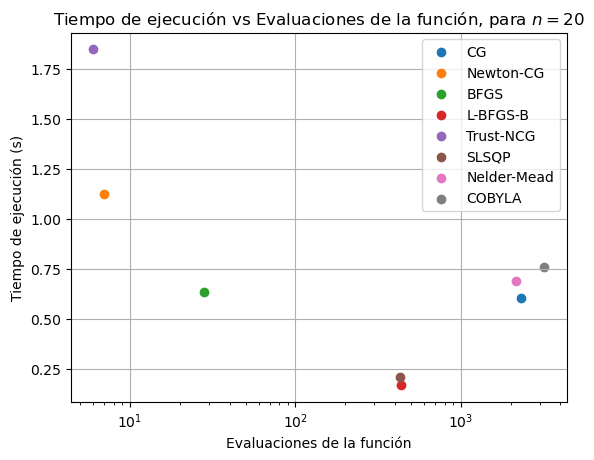

In [ ]:
plt.scatter(optimizer_CG.nfev, time_CG[-1], label='CG')
plt.scatter(optimizer_Newton_CG.nfev, time_Newton_CG[-1], label='Newton-CG')
plt.scatter(optimizer_BFGS.nfev, time_BFGS[-1], label='BFGS')
plt.scatter(sol_LBFGSB.nfev, time_LBFGSB[-1], label='L-BFGS-B')
plt.scatter(sol_trustncg.nfev, time_trustncg[-1], label='Trust-NCG')
plt.scatter(sol_SLSQP.nfev, time_SLSQP[-1], label='SLSQP')
plt.scatter(sol_nelder.nfev, time_nelder[-1], label='Nelder-Mead')
plt.scatter(sol_cobyla.nfev, time_cobyla[-1], label='COBYLA')
plt.legend()
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('Evaluaciones de la función')
plt.title('Tiempo de ejecución vs Evaluaciones de la función, para $n = {}$'.format(n))
plt.xscale('log')
plt.grid(True)
plt.show()

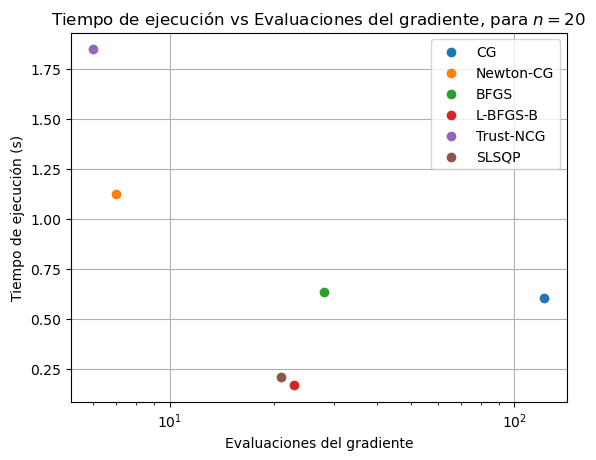

In [ ]:
plt.scatter(optimizer_CG.njev, time_CG[-1], label='CG')
plt.scatter(optimizer_Newton_CG.njev, time_Newton_CG[-1], label='Newton-CG')
plt.scatter(optimizer_BFGS.njev, time_BFGS[-1], label='BFGS')
plt.scatter(sol_LBFGSB.njev, time_LBFGSB[-1], label='L-BFGS-B')
plt.scatter(sol_trustncg.njev, time_trustncg[-1], label='Trust-NCG')
plt.scatter(sol_SLSQP.njev, time_SLSQP[-1], label='SLSQP')
plt.legend()
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('Evaluaciones del gradiente')
plt.title('Tiempo de ejecución vs Evaluaciones del gradiente, para $n = {}$'.format(n))
plt.xscale('log')
plt.grid(True)
plt.show()

En este caso, siendo bajo el número de puntos y, por tanto, baja la dimensionalidad del problema, resulta barato computacionalmente evaluar la función un número elevado de veces, como se manifiesta de los resultados de métodos como, por ejemplo, COBYLA, Nelder-Mead o Gradiente Conjugado. 

También es importante recalcar la gran diferencia que se encuentra entre los métodos de Newton (tanto Newton-Gradiente Conjugado como este mismo con la inclusión de las regiones de confianza) y le resto de métodos, sinebndo los basados en el método de Newton mucho más lentos, pese a evaluar tanto la función como el gradiente el menor número de veces. esto es debido a que son métodos que también requieren de evaluart la Hessiana, lo que aumenta significativamente el tiempo de computación necesario para resolver dichos problemas, especialmente en estos casos tan sencillos donde pueden no ser necesarios métodos tan sofisticados y es más fácil evaluar un número grande de veces la función.

##### Funciones con moderadas variables de salida: $n = 100$.

In [ ]:
n = 100
z = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
Fcat = catenaria(z)

1. **Método del *Steepest Descent* (descenso más pronunciado)**.

In [ ]:
# time_start = time.time()

# optimizer_steepest = SteepestDescent(area_func, F_init)
# optimizer_steepest.run()

# time_end = time.time()
# time_steepest = time_end - time_start
# Famp_steepest = np.concatenate(([F0], optimizer_steepest.x, [F1]))

In [ ]:
# print(optimizer_steepest.message)
# print('Valor de la función:', optimizer_steepest.fun)
# # print('Resultado:', optimizer_steepest.x)
# print('Evaluaciones de la función:', optimizer_steepest.nfev)
# print('Tiempo de ejecución:', time_steepest)

2. ***Conjugate Gradient* (gradiente conjugado)**.

In [ ]:
# time_start = time.time()

# optimizer_CG = minimize(area_func, F_init, method='CG', options={'maxiter': 100000}) # no se pueden imponer restricciones

# time_end = time.time()
# time_CG = np.append(time_CG, time_end - time_start)
# Famp_CG = np.concatenate(([F0], optimizer_CG.x, [F1]))
# error_CG = np.append(error_CG, np.linalg.norm(Famp_CG - Fcat))

In [ ]:
# print(optimizer_CG.message)
# print('Valor de la función:', optimizer_CG.fun)
# # print('Resultado:', optimizer_CG.x)
# print('Evaluaciones de la función:', optimizer_CG.nfev)
# print('Tiempo de ejecución:', time_CG[-1])
# print('Evaluaciones del gradiente:', optimizer_CG.njev)
# print('El error para el método de Newton-CG es:', error_CG[-1])

3. **Método de Newton de gradiente conjugado**.

In [ ]:
# time_start = time.time()

# optimizer_Newton_CG = minimize(area_func, F_init, method='Newton-CG', jac=area_func_grad, hess=area_func_hessian, options={'maxiter': 100000})

# time_end = time.time()
# time_Newton_CG = np.append(time_Newton_CG, time_end - time_start)
# Famp_Newton_CG = np.concatenate(([F0], optimizer_Newton_CG.x, [F1]))
# error_Newton_CG = np.append(error_Newton_CG, np.linalg.norm(Famp_Newton_CG - Fcat))

In [ ]:
# print(optimizer_Newton_CG.message)
# print('Valor de la función:', optimizer_Newton_CG.fun)
# # print('Resultado:', optimizer_Newton_CG.x)
# print('Evaluaciones de la función:', optimizer_Newton_CG.nfev)
# print('Tiempo de ejecución:', time_Newton_CG[-1])
# print('Evaluaciones del gradiente:', optimizer_Newton_CG.njev)
# print('El error para el método de Newton-CG es:', error_Newton_CG[-1])

4. **Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS)** (quasi-Newton).

In [ ]:
# time_start = time.time()

# optimizer_BFGS = minimize(area_func, F_init, method='BFGS', jac=area_func_grad, options={'maxiter': 100000})

# time_end = time.time()
# time_BFGS = np.append(time_BFGS, time_end - time_start)
# Famp_BFGS = np.concatenate(([F0], optimizer_BFGS.x, [F1]))
# error_BFGS = np.append(error_BFGS, np.linalg.norm(Famp_BFGS - Fcat))

In [ ]:
# print(optimizer_BFGS.message)
# print('Valor de la función:', optimizer_BFGS.fun)
# # print('Resultado:', optimizer_BFGS.x)
# print('Evaluaciones de la función:', optimizer_BFGS.nfev)
# print('Tiempo de ejecución:', time_BFGS[-1])
# print('Evaluaciones del gradiente:', optimizer_BFGS.njev)
# print('El error para el método de BFGS es:', error_BFGS[-1])

5. ***Limited-memory BFGS with Bound constraints* (L-BFGS-B)**.

In [ ]:
# time_start = time.time()

# sol_LBFGSB = minimize(area_func, F_init, method='L-BFGS-B', bounds=bounds, options={'maxiter': 100000})

# time_end = time.time()
# time_LBFGSB = np.append(time_LBFGSB, time_end - time_start)
# Famp_LBFGSB = np.concatenate(([F0], sol_LBFGSB.x, [F1]))
# error_LBFGSB = np.append(error_LBFGSB, np.linalg.norm(Famp_LBFGSB - Fcat))

In [ ]:
# print(sol_LBFGSB.message)
# print('Valor de la función:', sol_LBFGSB.fun)
# # print('Resultado:', sol_LBFGSB.x)
# print('Evaluaciones de la función:', sol_LBFGSB.nfev)
# print('Tiempo de ejecución:', time_LBFGSB[-1])
# print('Evaluaciones del gradiente:', sol_LBFGSB.njev)
# print('El error para el método de L-BFGS-B es:', error_LBFGSB[-1])

6. ***Newton Conjugate Gradient Trust-Region***.

In [ ]:
# time_start = time.time()

# sol_trustncg = minimize(area_func, F_init, method='trust-ncg', jac=area_func_grad, hess=area_func_hessian, options={'maxiter': 100000})

# time_end = time.time()
# time_trustncg = np.append(time_trustncg, time_end - time_start)
# Famp_trustncg = np.concatenate(([F0], sol_trustncg.x, [F1]))
# error_trustncg = np.append(error_trustncg, np.linalg.norm(Famp_trustncg - Fcat))

In [ ]:
# print(sol_trustncg.message)
# print('Valor de la función:', sol_trustncg.fun)
# # print('Resultado:', sol_trustncg.x)
# print('Evaluaciones de la función:', sol_trustncg.nfev)
# print('Tiempo de ejecución:', time_trustncg[-1])
# print('Evaluaciones del gradiente:', sol_trustncg.njev)
# print('El error para el método de trust-ncg es:', error_trustncg[-1])

7. ***Sequential Least Squares Programming* (SLSQP)**.

In [ ]:
# start = time.time()

# sol_SLSQP = minimize(area_func, F_init, method='SLSQP', bounds=bounds, options={'maxiter': 100000})

# end = time.time()
# time_SLSQP = np.append(time_SLSQP, end - start)
# Famp_SLSQP = np.concatenate(([F0], sol_SLSQP.x, [F1]))
# error_SLSQP = np.append(error_SLSQP, np.linalg.norm(Famp_SLSQP - Fcat))

In [ ]:
# print(sol_SLSQP.message)
# print('Valor de la función:', sol_SLSQP.fun)
# # print('Resultado:', sol_SLSQP.x)
# print('Evaluaciones de la función:', sol_SLSQP.nfev)
# print('Tiempo de ejecución:', time_SLSQP[-1])
# print('Evaluaciones del gradiente:', sol_SLSQP.njev)
# print('El error para el método de SLSQP es:', error_SLSQP[-1])

8. **Nelder-Mead**.

In [ ]:
# time_start = time.time()

# sol_nelder = minimize(area_func, F_init, method='Nelder-Mead', bounds=bounds, options={'maxiter': 1000000})

# time_end = time.time()
# time_nelder = np.append(time_nelder, time_end - time_start)
# Famp_nelder = np.concatenate(([F0], sol_nelder.x, [F1]))
# error_nelder = np.append(error_nelder, np.linalg.norm(Famp_nelder - Fcat))

In [ ]:
# print(sol_nelder.message)
# print('Valor de la función:', sol_nelder.fun)
# # print('Resultado:', sol_nelder.x)
# print('Evaluaciones de la función:', sol_nelder.nfev)
# print('Tiempo de ejecución:', time_nelder[-1])
# print('El error para el método de Nelder-Mead es:', error_nelder[-1])

9. ***Constrained Optimization BY Linear Approximation* (COBYLA)**.

In [ ]:
# time_start = time.time()

# sol_cobyla = minimize(area_func, F_init, method='COBYLA', bounds=bounds, options={'maxiter': 1000000})

# time_end = time.time()
# time_cobyla = np.append(time_cobyla, time_end - time_start)
# Famp_cobyla = np.concatenate(([F0], sol_cobyla.x, [F1]))
# error_cobyla = np.append(error_cobyla, np.linalg.norm(Famp_cobyla - Fcat))

In [ ]:
# print(sol_cobyla.message)
# print('Valor de la función:', sol_cobyla.fun)
# # print('Resultado:', sol_cobyla.x)
# print('Evaluaciones de la función:', sol_cobyla.nfev)
# print('Tiempo de ejecución:', time_cobyla[-1])
# print('El error para el método de COBYLA es:', error_cobyla[-1])

In [ ]:
# plt.scatter(optimizer_CG.nfev, time_CG[-1], label='CG')
# plt.scatter(optimizer_Newton_CG.nfev, time_Newton_CG[-1], label='Newton-CG')
# plt.scatter(optimizer_BFGS.nfev, time_BFGS[-1], label='BFGS')
# plt.scatter(sol_LBFGSB.nfev, time_LBFGSB[-1], label='L-BFGS-B')
# plt.scatter(sol_trustncg.nfev, time_trustncg[-1], label='Trust-NCG')
# plt.scatter(sol_SLSQP.nfev, time_SLSQP[-1], label='SLSQP')
# plt.scatter(sol_nelder.nfev, time_nelder[-1], label='Nelder-Mead')
# plt.scatter(sol_cobyla.nfev, time_cobyla[-1], label='COBYLA')
# plt.legend()
# plt.ylabel('Tiempo de ejecución (s)')
# plt.xlabel('Evaluaciones de la función')
# plt.xscale('log')
# plt.title('Tiempo de ejecución vs Evaluaciones de la función, para $n = {}$'.format(n))
# plt.grid(True)
# plt.show()

In [ ]:
# plt.scatter(optimizer_CG.njev, time_CG[-1], label='CG')
# plt.scatter(optimizer_Newton_CG.njev, time_Newton_CG[-1], label='Newton-CG')
# plt.scatter(optimizer_BFGS.njev, time_BFGS[-1], label='BFGS')
# plt.scatter(sol_LBFGSB.njev, time_LBFGSB[-1], label='L-BFGS-B')
# plt.scatter(sol_trustncg.njev, time_trustncg[-1], label='Trust-NCG')
# plt.scatter(sol_SLSQP.njev, time_SLSQP[-1], label='SLSQP')
# plt.legend()
# plt.ylabel('Tiempo de ejecución (s)')
# plt.xlabel('Evaluaciones del gradiente')
# plt.title('Tiempo de ejecución vs Evaluaciones del gradiente, para $n = {}$'.format(n))
# plt.xscale('log')
# plt.grid(True)
# plt.show()

Una vez se aumenta considerablemente el número de puntos, cambia la tendencia de la solución en función del método empleado. Se aprecia que métodos que no hacen uso del gradiente y evaluan la función un número grande de ves, como son el COBYLA o el Nelder-Mead suponen un coste elevadísimo que incrementa el tiempo necesario para alcanzar la solución del problema.

Por otro lado, se aprecia como métodos más complejos pero que pueden resultar más robustos (BGFS, L-BFGS-B o SLSQP), mantienen unos tiempos de computación excelentes, pese a haber aumentado en gran medida la complicación del problema.

##### Funciones muchas variables de salida: $n = 400$.

In [ ]:
n = 400
z = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
Fcat = catenaria(z)

1. **Método del *Steepest Descent* (descenso más pronunciado)**.

In [ ]:
# time_start = time.time()

# optimizer_steepest = SteepestDescent(area_func, F_init)
# optimizer_steepest.run()

# time_end = time.time()
# time_steepest = time_end - time_start
# Famp_steepest = np.concatenate(([F0], optimizer_steepest.x, [F1]))

In [ ]:
# print(optimizer_steepest.message)
# print('Valor de la función:', optimizer_steepest.fun)
# # print('Resultado:', optimizer_steepest.x)
# print('Evaluaciones de la función:', optimizer_steepest.nfev)
# print('Tiempo de ejecución:', time_steepest)

2. ***Conjugate Gradient* (gradiente conjugado)**.

In [ ]:
# time_start = time.time()

# optimizer_CG = minimize(area_func, F_init, method='CG', options={'maxiter': 100000}) # no se pueden imponer restricciones

# time_end = time.time()
# time_CG = np.append(time_CG, time_end - time_start)
# Famp_CG = np.concatenate(([F0], optimizer_CG.x, [F1]))
# error_CG = np.append(error_CG, np.linalg.norm(Famp_CG - Fcat))

In [ ]:
# print(optimizer_CG.message)
# print('Valor de la función:', optimizer_CG.fun)
# # print('Resultado:', optimizer_CG.x)
# print('Evaluaciones de la función:', optimizer_CG.nfev)
# print('Tiempo de ejecución:', time_CG[-1])
# print('Evaluaciones del gradiente:', optimizer_CG.njev)
# print('El error para el método de Newton-CG es:', error_CG[-1])

3. **Método de Newton de gradiente conjugado**.

In [ ]:
# time_start = time.time()

# optimizer_Newton_CG = minimize(area_func, F_init, method='Newton-CG', jac=area_func_grad, hess=area_func_hessian, options={'maxiter': 100000})

# time_end = time.time()
# time_Newton_CG = np.append(time_Newton_CG, time_end - time_start)
# Famp_Newton_CG = np.concatenate(([F0], optimizer_Newton_CG.x, [F1]))
# error_Newton_CG = np.append(error_Newton_CG, np.linalg.norm(Famp_Newton_CG - Fcat))

In [ ]:
# print(optimizer_Newton_CG.message)
# print('Valor de la función:', optimizer_Newton_CG.fun)
# # print('Resultado:', optimizer_Newton_CG.x)
# print('Evaluaciones de la función:', optimizer_Newton_CG.nfev)
# print('Tiempo de ejecución:', time_Newton_CG[-1])
# print('Evaluaciones del gradiente:', optimizer_Newton_CG.njev)
# print('El error para el método de Newton-CG es:', error_Newton_CG[-1])

4. **Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS)** (quasi-Newton).

In [ ]:
# time_start = time.time()

# optimizer_BFGS = minimize(area_func, F_init, method='BFGS', jac=area_func_grad, options={'maxiter': 100000})

# time_end = time.time()
# time_BFGS = np.append(time_BFGS, time_end - time_start)
# Famp_BFGS = np.concatenate(([F0], optimizer_BFGS.x, [F1]))
# error_BFGS = np.append(error_BFGS, np.linalg.norm(Famp_BFGS - Fcat))

In [ ]:
# print(optimizer_BFGS.message)
# print('Valor de la función:', optimizer_BFGS.fun)
# # print('Resultado:', optimizer_BFGS.x)
# print('Evaluaciones de la función:', optimizer_BFGS.nfev)
# print('Tiempo de ejecución:', time_BFGS[-1])
# print('Evaluaciones del gradiente:', optimizer_BFGS.njev)
# print('El error para el método de BFGS es:', error_BFGS[-1])

5. ***Limited-memory BFGS with Bound constraints* (L-BFGS-B)**.

In [ ]:
# time_start = time.time()

# sol_LBFGSB = minimize(area_func, F_init, method='L-BFGS-B', bounds=bounds, options={'maxiter': 100000})

# time_end = time.time()
# time_LBFGSB = np.append(time_LBFGSB, time_end - time_start)
# Famp_LBFGSB = np.concatenate(([F0], sol_LBFGSB.x, [F1]))
# error_LBFGSB = np.append(error_LBFGSB, np.linalg.norm(Famp_LBFGSB - Fcat))

In [ ]:
# print(sol_LBFGSB.message)
# print('Valor de la función:', sol_LBFGSB.fun)
# # print('Resultado:', sol_LBFGSB.x)
# print('Evaluaciones de la función:', sol_LBFGSB.nfev)
# print('Tiempo de ejecución:', time_LBFGSB[-1])
# print('Evaluaciones del gradiente:', sol_LBFGSB.njev)
# print('El error para el método de L-BFGS-B es:', error_LBFGSB[-1])

6. ***Newton Conjugate Gradient Trust-Region***.

In [ ]:
# time_start = time.time()

# sol_trustncg = minimize(area_func, F_init, method='trust-ncg', jac=area_func_grad, hess=area_func_hessian, options={'maxiter': 100000})

# time_end = time.time()
# time_trustncg = np.append(time_trustncg, time_end - time_start)
# Famp_trustncg = np.concatenate(([F0], sol_trustncg.x, [F1]))
# error_trustncg = np.append(error_trustncg, np.linalg.norm(Famp_trustncg - Fcat))

In [ ]:
# print(sol_trustncg.message)
# print('Valor de la función:', sol_trustncg.fun)
# # print('Resultado:', sol_trustncg.x)
# print('Evaluaciones de la función:', sol_trustncg.nfev)
# print('Tiempo de ejecución:', time_trustncg[-1])
# print('Evaluaciones del gradiente:', sol_trustncg.njev)
# print('El error para el método de trust-ncg es:', error_trustncg[-1])

7. ***Sequential Least Squares Programming* (SLSQP)**.

In [ ]:
# start = time.time()

# sol_SLSQP = minimize(area_func, F_init, method='SLSQP', bounds=bounds, options={'maxiter': 100000})

# end = time.time()
# time_SLSQP = np.append(time_SLSQP, end - start)
# Famp_SLSQP = np.concatenate(([F0], sol_SLSQP.x, [F1]))
# error_SLSQP = np.append(error_SLSQP, np.linalg.norm(Famp_SLSQP - Fcat))

In [ ]:
# print(sol_SLSQP.message)
# print('Valor de la función:', sol_SLSQP.fun)
# # print('Resultado:', sol_SLSQP.x)
# print('Evaluaciones de la función:', sol_SLSQP.nfev)
# print('Tiempo de ejecución:', time_SLSQP[-1])
# print('Evaluaciones del gradiente:', sol_SLSQP.njev)
# print('El error para el método de SLSQP es:', error_SLSQP[-1])

8. **Nelder-Mead**.

In [ ]:
# time_start = time.time()

# sol_nelder = minimize(area_func, F_init, method='Nelder-Mead', bounds=bounds, options={'maxiter': 100000})

# time_end = time.time()
# time_nelder = np.append(time_nelder, time_end - time_start)
# Famp_nelder = np.concatenate(([F0], sol_nelder.x, [F1]))
# error_nelder = np.append(error_nelder, np.linalg.norm(Famp_nelder - Fcat))

In [ ]:
# print(sol_nelder.message)
# print('Valor de la función:', sol_nelder.fun)
# # print('Resultado:', sol_nelder.x)
# print('Evaluaciones de la función:', sol_nelder.nfev)
# print('Tiempo de ejecución:', time_nelder[-1])
# print('El error para el método de Nelder-Mead es:', error_nelder[-1])

9. ***Constrained Optimization BY Linear Approximation* (COBYLA)**.

In [ ]:
# time_start = time.time()

# sol_cobyla = minimize(area_func, F_init, method='COBYLA', bounds=bounds, options={'maxiter': 100000})

# time_end = time.time()
# time_cobyla = np.append(time_cobyla, time_end - time_start)
# Famp_cobyla = np.concatenate(([F0], sol_cobyla.x, [F1]))
# error_cobyla = np.append(error_cobyla, np.linalg.norm(Famp_cobyla - Fcat))

In [ ]:
# print(sol_cobyla.message)
# print('Valor de la función:', sol_cobyla.fun)
# # print('Resultado:', sol_cobyla.x)
# print('Evaluaciones de la función:', sol_cobyla.nfev)
# print('Tiempo de ejecución:', time_cobyla[-1])
# print('El error para el método de COBYLA es:', error_cobyla[-1])

In [ ]:
# plt.scatter(optimizer_CG.nfev, time_CG[-1], label='CG')
# plt.scatter(optimizer_Newton_CG.nfev, time_Newton_CG[-1], label='Newton-CG')
# plt.scatter(optimizer_BFGS.nfev, time_BFGS[-1], label='BFGS')
# plt.scatter(sol_LBFGSB.nfev, time_LBFGSB[-1], label='L-BFGS-B')
# plt.scatter(sol_trustncg.nfev, time_trustncg[-1], label='Trust-NCG')
# plt.scatter(sol_SLSQP.nfev, time_SLSQP[-1], label='SLSQP')
# plt.scatter(sol_nelder.nfev, time_nelder[-1], label='Nelder-Mead')
# plt.scatter(sol_cobyla.nfev, time_cobyla[-1], label='COBYLA')
# plt.legend()
# plt.ylabel('Tiempo de ejecución (s)')
# plt.xlabel('Evaluaciones de la función')
# plt.title('Tiempo de ejecución vs Evaluaciones de la función, para $n = {}$'.format(n))
# plt.xscale('log')
# plt.grid(True)
# plt.show()

In [ ]:
# plt.scatter(optimizer_CG.njev, time_CG[-1], label='CG')
# plt.scatter(optimizer_Newton_CG.njev, time_Newton_CG[-1], label='Newton-CG')
# plt.scatter(optimizer_BFGS.njev, time_BFGS[-1], label='BFGS')
# plt.scatter(sol_LBFGSB.njev, time_LBFGSB[-1], label='L-BFGS-B')
# plt.scatter(sol_trustncg.njev, time_trustncg[-1], label='Trust-NCG')
# plt.scatter(sol_SLSQP.njev, time_SLSQP[-1], label='SLSQP')
# plt.legend()
# plt.ylabel('Tiempo de ejecución (s)')
# plt.xlabel('Evaluaciones del gradiente')
# plt.title('Tiempo de ejecución vs Evaluaciones del gradiente, para $n = {}$'.format(n))
# plt.xscale('log')
# plt.grid(True)
# plt.show()

Para este último caso, se han aumentado los puntos muy por encima de lo que sería incluso recomendable para alcanzar la solución, solo a fin de estudiar el comportamiento de los algoritmos cuando se les fuerza en una función de alta dimensionalidad.

Por encima de todos los resultados, se distingue el mal comportamiento del algoritmo del Gradiente Conjugado. Esto era de esperar ya que, siendo un método tan simple, al aumentar la complicación del problema responde peor de lo que lo hacen el resto, siendo el que requiere más evaluaciones de la función, más del gradiente y a su vez el que tarda más tiempo en converger a una solución.

Por otro lado, vuelven a destacar los métodos BGFS, L-BFGS-B y SLSQP por su rapidez, manteniendo la robustez que antes se comentaba.

In [ ]:
# plt.plot(time_CG, error_CG, label = 'CG')
# plt.plot(time_Newton_CG, error_Newton_CG, label = 'Newton-CG')
# plt.plot(time_BFGS, error_BFGS, label = 'BFGS')
# plt.plot(time_LBFGSB, error_LBFGSB, label = 'L-BFGS-B')
# plt.plot(time_trustncg, error_trustncg, label = 'Trust-NCG')
# plt.plot(time_SLSQP, error_SLSQP, label = 'SLSQP')
# plt.plot(time_nelder, error_nelder, label = 'Nelder-Mead')
# # plt.plot(time_cobyla, error_cobyla, label = 'COBYLA')
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')
# plt.ylabel('Error')
# plt.xlabel('tiempo (s)')
# plt.title('Error en función de n')
# plt.grid(True)
# plt.show()

#### Influencia del valor de arranque para la iteración.

Otro parámetro que puede influir en las características de la solución obtenida es el valor que se escoja de arranque en la iteración, lo que equivale al punto escogido desde el que arrancar el método de basado en gradiente que se escoja. 

En principio, se ha escogido para este valor un caso de $F(z) = F_0 \quad , \forall z \in [0, 1]$, pero a continuación se propone inicializar en distintos valores, que se detallan a continuación. 

En todos estos se considera $F_0 = 1$, por lo que se omite en las expresiones.

In [188]:
n = 20
F_0 = 1
F0 = F_0
F1 = F_0
z = np.linspace(0, 1, n)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
Fcat = catenaria(z)

1. $F(z) = 1 \quad , \forall z \in [0, 1]$

In [189]:
F_init = np.empty(n-2)
F_init.fill(F_0)

sol_F0 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Famp_F0 = np.concatenate(([F0], sol_F0.x, [F1]))
error_F0 = np.linalg.norm(Famp_F0 - Fcat)

In [208]:
print(sol_F0.message)
# print('Valor de la función:', sol_F0.fun)
# print('Resultado:', sol_F0.x)
print('Evaluaciones de la función:', sol_F0.nfev)
print('El error para F_inic=1 es:', error_F0)

Optimization terminated successfully
Evaluaciones de la función: 429
El error para F_inic=1 es: 0.004135763067604287


Como se ha comprobado anteriormente, al alcanzar un valor del error de $\approx 4 \cdot 10^{-3} $ se considera que la función ha llegado al mínimo que permiten las condiciones del problema. Por tanto, para comparar si la solución a la que ha convergido cada método es la correcta, se procederá a comparar dichos valores.

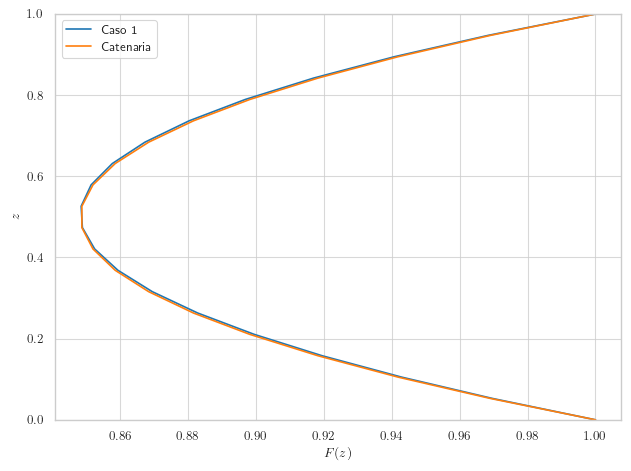

In [191]:
plt.figure()
plt.plot(Famp_F0, z, label= 'Caso 1')
# plt.plot(Famp_0, z, label= 'Caso 2')
# plt.plot(Famp_F06, z, label= 'Caso 3')
# plt.plot(Famp_F2, z, label= 'Caso 4')
# plt.plot(Famp_F10, z, label= 'Caso 5')
# plt.plot(Famp_rand, z, label= 'Caso 6')
plt.plot(Fcat, z, label='Catenaria')
plt.legend()
plt.xlabel('$F(z)$')
plt.ylabel('$z$')
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('Figuras/sol_cambioF.pdf', format='pdf') 
plt.show()

2. $F(z) = 0 \quad , \forall z \in [0, 1]$

In [192]:
F_init = np.zeros(n-2)

sol_0 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Famp_0 = np.concatenate(([F0], sol_0.x, [F1]))
error_0 = np.linalg.norm(Famp_0 - Fcat)

In [193]:
print(sol_0.message)
# print('Valor de la función:', sol_0.fun)
# print('Resultado:', sol_0.x)
print('Evaluaciones de la función:', sol_0.nfev)
print('El error para F_inic=0 es:', error_0)

Optimization terminated successfully
Evaluaciones de la función: 249
El error para F_inic=0 es: 3.2747521363306227


Como se ha mencionado antes, aunque el resultado de la iteración indique que se ha conseguido minimizar la función, del valor del error se observa que no es así. Esto se debe a que los valores de arranque pueden condicionar enormemente la capacidad de llegar a una solución válida. 

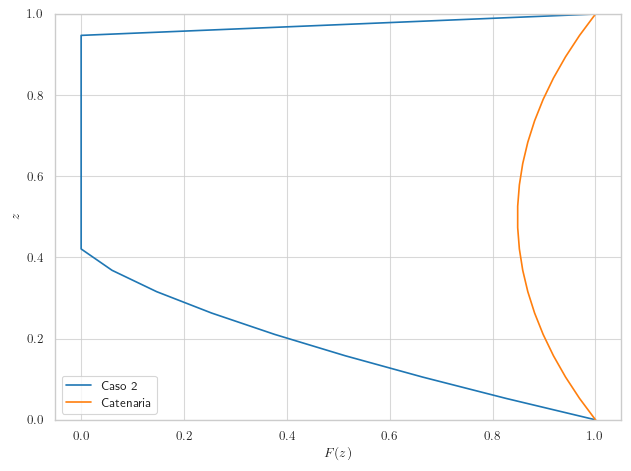

In [194]:
plt.figure()
# plt.plot(Famp_F0, z, label= 'Caso 1')
plt.plot(Famp_0, z, label= 'Caso 2')
# plt.plot(Famp_F06, z, label= 'Caso 3')
# plt.plot(Famp_F2, z, label= 'Caso 4')
# plt.plot(Famp_F10, z, label= 'Caso 5')
# plt.plot(Famp_rand, z, label= 'Caso 6')
plt.plot(Fcat, z, label='Catenaria')
plt.legend()
plt.xlabel('$F(z)$')
plt.ylabel('$z$')
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('Figuras/sol_cambioF.pdf', format='pdf') 
plt.show()

3. $F(z) \leq 0.6  \quad , \forall z \in [0, 1]$

In [195]:
F_init = np.empty(n-2)
F_init.fill(F_0 * 0.6)

sol_F06 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Famp_F06 = np.concatenate(([F0], sol_F06.x, [F1]))
error_F06 = np.linalg.norm(Famp_F06 - Fcat)

In [215]:
print(sol_F06.message)
# print('Valor de la función:', sol_F06.fun)
# print('Resultado:', sol_F06.x)
print('Evaluaciones de la función:', sol_F06.nfev)
print('El error para F_inic=0.6 es:', error_F06)
print('Valor del area:', area_func(sol_F06.x))

Optimization terminated successfully
Evaluaciones de la función: 739
El error para F_inic=0.6 es: 3.2743654701130898
Valor del area: 0.60393299489359


Al igual que en el caso anterior, se encuentra que para valores iniciales de la iteración demasiado cercanos al origen, el algoritmo no es capaz de converger a la solución correcta. 

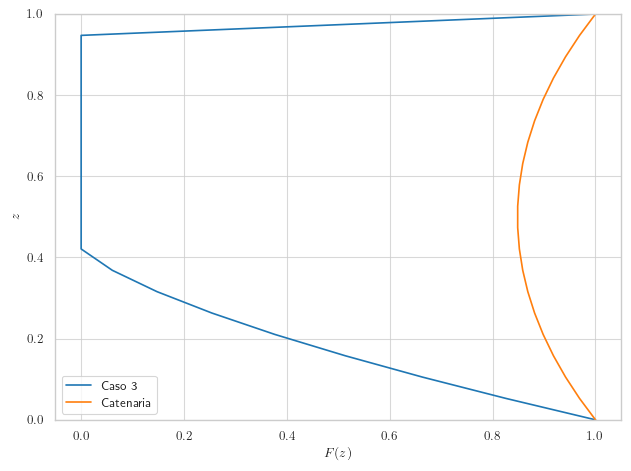

In [213]:
plt.figure()
# plt.plot(Famp_F0, z, label= 'Caso 1')
# plt.plot(Famp_0, z, label= 'Caso 2')
plt.plot(Famp_F06, z, label= 'Caso 3')
# plt.plot(Famp_F2, z, label= 'Caso 4')
# plt.plot(Famp_F10, z, label= 'Caso 5')
# plt.plot(Famp_rand, z, label= 'Caso 6')
plt.plot(Fcat, z, label='Catenaria')
plt.legend()
plt.xlabel('$F(z)$')
plt.ylabel('$z$')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('Figuras/sol_cambioF0.pdf', format='pdf') 
plt.show()

4. $0.6 < F(z) < 2 \quad , \forall z \in [0, 1]$

In [221]:
F_init = np.empty(n-2)
F_init.fill(F_0 * 2)

sol_F2 = minimize(area_func, F_init, bounds=bounds, method='SLSQP', options={'maxiter': 100000})
Famp_F2 = np.concatenate(([F0], sol_F2.x, [F1]))
error_F2 = np.linalg.norm(Famp_F2 - Fcat)

In [222]:
print(sol_F2.message)
# print('Valor de la función:', sol_F2.fun)
# print('Resultado:', sol_F2.x)
print('Evaluaciones de la función:', sol_F2.nfev)
print('El error para F_inic=2 es:', error_F2)

Optimization terminated successfully
Evaluaciones de la función: 615
El error para F_inic=2 es: 0.003747953686174385


Como podía llegar a inferirse, no es necesario que el algoritmo arranque exactamente en el valor de $F_0$, ya que eso provocaría muy poca robustez en la resolución del problema. Existe un intervalo que llamaremos "zona óptima de arranque" en la que los valores de la función pueden inicializarse y el algoritmo conseguirá converger para llegar a la solución adecuada. 

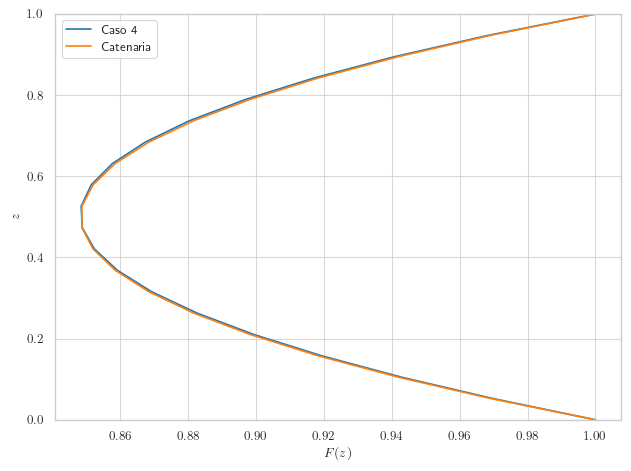

In [200]:
plt.figure()
# plt.plot(Famp_F0, z, label= 'Caso 1')
# plt.plot(Famp_0, z, label= 'Caso 2')
# plt.plot(Famp_F06, z, label= 'Caso 3')
plt.plot(Famp_F2, z, label= 'Caso 4')
# plt.plot(Famp_F10, z, label= 'Caso 5')
# plt.plot(Famp_rand, z, label= 'Caso 6')
plt.plot(Fcat, z, label='Catenaria')
plt.legend()
plt.xlabel('$F(z)$')
plt.ylabel('$z$')
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('Figuras/sol_cambioF.pdf', format='pdf') 
plt.show()

5. $F(z) \gg 2 \quad , \forall z \in [0, 1]$

In [201]:
F_init = np.empty(n-2)
F_init.fill(F_0 * 10)

sol_F10 = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Famp_F10 = np.concatenate(([F0], sol_F10.x, [F1]))
error_F10 = np.linalg.norm(Famp_F10 - Fcat)

In [202]:
print(sol_F10.message)
# print('Valor de la función:', sol_F10.fun)
# print('Resultado:', sol_F10.x)
print('Evaluaciones de la función:', sol_F10.nfev)
print('El error para F_inic=10 es:', error_F10)

Optimization terminated successfully
Evaluaciones de la función: 1013
El error para F_inic=10 es: 3.2744732026272643


Al igual que en los puntos por debajo de la cota inferior de la zona óptima de arranque, los que se sitúan por encima llegan a una solución inadecuada, y esto se mantiene para todos los valores mayores que 2, según el análisis que se ha llevado a cabo.

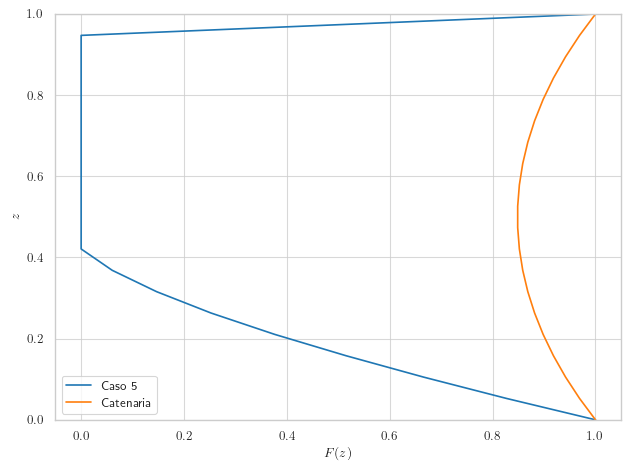

In [203]:
plt.figure()
# plt.plot(Famp_F0, z, label= 'Caso 1')
# plt.plot(Famp_0, z, label= 'Caso 2')
# plt.plot(Famp_F06, z, label= 'Caso 3')
# plt.plot(Famp_F2, z, label= 'Caso 4')
plt.plot(Famp_F10, z, label= 'Caso 5')
# plt.plot(Famp_rand, z, label= 'Caso 6')
plt.plot(Fcat, z, label='Catenaria')
plt.legend()
plt.xlabel('$F(z)$')
plt.ylabel('$z$')
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('Figuras/sol_cambioF.pdf', format='pdf') 
plt.show()

6. $F(z) \sim \text{U}(0.6, 2)$

In [211]:
F_init = np.random.uniform(size=n-2)*1.4 + 0.6

sol_rand = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Famp_rand = np.concatenate(([F0], sol_rand.x, [F1]))
error_rand = np.linalg.norm(Famp_rand - Fcat)

In [212]:
print(sol_rand.message)
# print('Valor de la función:', sol_rand.fun)
# print('Resultado:', sol_rand.x)
print('Evaluaciones de la función:', sol_rand.nfev)
print('El error para F_inic=rand es:', error_rand)

Optimization terminated successfully
Evaluaciones de la función: 563
El error para F_inic=rand es: 0.003488971787649239


Otra pregunta que merece la pena hacerse es qué ocurriría si se inicializan valores aleatorios dentro de la zona óptima de arranque. 

Aunque existe la posibilidad de que el algoritmo converja a la solución correcta, lo cierto es que esto apenas sucede unas pocas veces y es imposible predecir en qué casos lo hará, por lo que no se considera un método robusto en el que se sepa que se va a alcanzar una solución óptima.

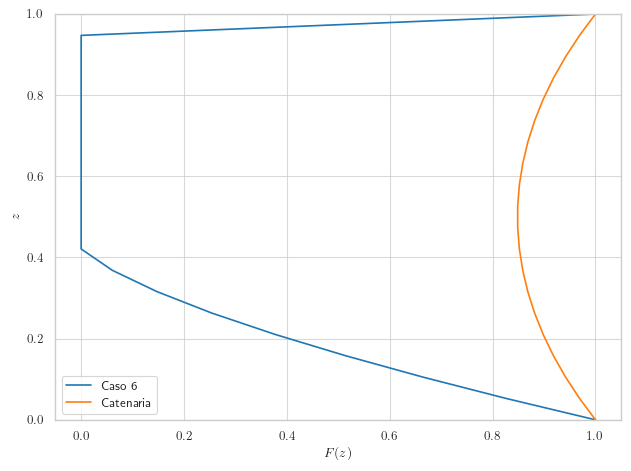

In [206]:
plt.figure()
# plt.plot(Famp_F0, z, label= 'Caso 1')
# plt.plot(Famp_0, z, label= 'Caso 2')
# plt.plot(Famp_F06, z, label= 'Caso 3')
# plt.plot(Famp_F2, z, label= 'Caso 4')
# plt.plot(Famp_F10, z, label= 'Caso 5')
plt.plot(Famp_rand, z, label= 'Caso 6')
plt.plot(Fcat, z, label='Catenaria')
plt.legend()
plt.xlabel('$F(z)$')
plt.ylabel('$z$')
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('Figuras/sol_cambioF.pdf', format='pdf') 
plt.show()

### Minimización con un método heurístico (Differential Evolution)

El algoritmo de evolución diferencial (DE) es una técnica de optimización global que pertenece a la familia de los algoritmos evolutivos. DE se utiliza principalmente para resolver problemas de optimización con variables continuas por sus ventajas frente a los algoritmos genéticos en este campo, como es el que se trata en el problema considerado.

**Principios Básicos de DE**

*Representación de las Soluciones*

Las soluciones se representan como vectores de números reales. Cada individuo en la población es un punto en el espacio de búsqueda multidimensional.

*Inicialización*

La población inicial se genera de manera aleatoria dentro de los límites especificados para cada variable. Esto asegura una buena cobertura inicial del espacio de búsqueda.

**Operadores Evolutivos**

*Mutación*

Genera un nuevo vector candidato sumando la diferencia ponderada entre dos vectores a un tercer vector. Este mecanismo introduce variabilidad basada en las diferencias entre individuos de la población.

$\mathbf{v}_i = \mathbf{x}_{r1} + F \cdot (\mathbf{x}_{r2} - \mathbf{x}_{r3})$

donde $\mathbf{x}_{r1}$, $\mathbf{x}_{r2}$ y $\mathbf{x}_{r3}$ son vectores aleatorios distintos seleccionados de la población, y $F$ es el factor de mutación que controla la amplitud de la variación diferencial.

*Recombinación (Crossover)*

Combina el vector mutado con el vector actual del individuo para crear un nuevo vector de prueba. Esto se realiza seleccionando componentes del vector mutado y del vector actual basándose en una tasa de recombinación.

$\mathbf{u}_{ij} = \begin{cases} 
\mathbf{v}_{ij} & \text{si } \text{rand}(0,1) < CR \text{ o } j = \text{randint}(0,D-1) \\
\mathbf{x}_{ij} & \text{de lo contrario}
\end{cases}$

donde $\text{rand}(0,1)$ es un número aleatorio entre 0 y 1, y $\text{randint}(0,D-1)$ asegura que al menos un componente provenga del vector mutado.

*Selección*

Compara el vector de prueba con el vector actual y selecciona el mejor (el que tenga la mejor aptitud) para la siguiente generación. Esto asegura que solo las soluciones más prometedoras sobrevivan.

$
\mathbf{x}_{i}^{(t+1)} = \begin{cases} 
\mathbf{u}_i & \text{si } f(\mathbf{u}_i) \leq f(\mathbf{x}_i) \\
\mathbf{x}_i & \text{de lo contrario}
\end{cases}
$

donde $f$ es la función objetivo a minimizar.

**Ventajas de Differential Evolution (DE)**

*Simplicidad*

DE es fácil de implementar y requiere menos parámetros que muchos otros algoritmos evolutivos, como los algoritmos genéticos. Los principales parámetros son el tamaño de la población, el factor de mutación y la tasa de recombinación.

*Eficiencia y Convergencia*

DE es conocido por su eficiencia en la búsqueda global y su capacidad para converger a soluciones óptimas o cercanas al óptimo, incluso en espacios de búsqueda complejos con múltiples óptimos locales.

*Robustez*

DE es robusto y eficaz en una amplia gama de problemas de optimización, incluidos aquellos con funciones objetivo no lineales y no convexas. La combinación de mutación y recombinación basada en diferencias permite una exploración efectiva del espacio de búsqueda.

*Mantenimiento de la Diversidad*

La mutación diferencial basada en las diferencias entre individuos ayuda a mantener la diversidad en la población, lo que es crucial para evitar el estancamiento en óptimos locales.

**Cuándo Usar Differential Evolution (DE)**

*Problemas de Optimización Continua*

DE es especialmente adecuado para problemas donde las variables son continuas y el espacio de búsqueda es multidimensional.

*Problemas No Lineales y No Convexos*

Es eficaz en problemas donde la función objetivo es no lineal y no convexa, y donde otros métodos de optimización pueden quedar atrapados en óptimos locales.

**Comparación con Algoritmos Genéticos (GA)**

*Mutación y Recombinación*

- **DE**: La mutación se basa en la diferencia entre individuos, lo que ayuda a explorar el espacio de búsqueda de manera más efectiva. La recombinación en DE combina el vector mutado con el vector actual del individuo.

- **GA**: La mutación en GA suele ser aleatoria y menos dirigida. La recombinación (cruce) en GA combina partes de dos o más padres para generar nuevos individuos.

*Diversidad Genética*

- **DE**: Mantiene la diversidad de manera más efectiva gracias a su mecanismo de mutación diferencial, lo que ayuda a evitar el estancamiento en óptimos locales.

- **GA**: La diversidad se mantiene mediante mutación y selección, pero puede ser más propenso a quedar atrapado en óptimos locales si no se gestiona adecuadamente.

*Parámetros*

- **DE**: Menos parámetros a ajustar, lo que simplifica su uso y ajuste. Los principales parámetros son el factor de mutación (F), la tasa de recombinación (CR) y el tamaño de la población.

- **GA**: Más parámetros a ajustar, incluyendo tasas de cruce y mutación, tamaños de torneos de selección, y más. Esto puede hacer que GA sea más complejo de ajustar.

*Aplicaciones*

- **DE**: Preferido para problemas de optimización continua y de alta dimensionalidad.

- **GA**: Más versátil y adecuado para problemas combinatorios, de variables discretas, y en aplicaciones donde la representación binaria es natural.

**Conclusión**

Differential Evolution (DE) es una poderosa técnica de optimización global que se destaca por su simplicidad, eficiencia y robustez en una amplia gama de problemas de optimización continua. Su capacidad para mantener la diversidad en la población y evitar quedar atrapado en óptimos locales lo hace especialmente útil para problemas no lineales y no convexos. Si bien los algoritmos genéticos (GA) ofrecen versatilidad en diferentes tipos de problemas, DE proporciona una solución más dirigida y eficaz para problemas de optimización continua y de alta dimensionalidad. La elección entre DE y otros métodos de optimización debe basarse en las características específicas del problema y en los objetivos de la optimización.

Así, en este trabajo se empleará DE por su implementación más sencilla, a través de la función `scipy.optimize.differential_evolution`. Esta aproxima la solución por el método estudiado y, posteriormente, se acerca a la solución definitiva con unos pocos pasos de un algoritmo basado en gradiente.

#### Caso de ejemplo

In [108]:
F_0 = 1
F0 = F_0
F1 = F_0
n = 20
z = np.linspace(0, 1, n)
F_init = np.empty(n-2)
F_init.fill(F_0)
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
Fcat = catenaria(z)

bounds = [(0.5, F_0) for _ in range(n-2)] 

Clase para registrar los valores de la función objetivo.

In [109]:
class ObjectiveLogger:
    def __init__(self):
        self.values = []
        self.iteration = 0

    def __call__(self, xk, convergence):
        value = area_func(xk)
        self.values.append(value)
        self.iteration += 1
        print(f"Iteración: {self.iteration}, Valor de la función: {value}")
        return False

    def reset(self):
        self.values = []
        self.iteration = 0

    def log_and_reset(self, func):
        def wrapped_func(*args, **kwargs):
            self.reset()
            return func(*args, **kwargs)
        return wrapped_func

# Crear una instancia del registrador de valores
logger = ObjectiveLogger()

# Envolver differential_evolution para que resetee automáticamente el logger
differential_evolution = logger.log_and_reset(differential_evolution)

Ejecutar la optimización con registro de valores.

In [110]:
time_start = time.time()

sol_hib = differential_evolution(
    area_func, 
    bounds=bounds, 
    maxiter=100000, 
    popsize=4*n, 
    mutation=(0.5, 1), 
    recombination=0.7, 
    strategy='best1bin', 
    tol=0.01, 
    callback=logger
)

time_end = time.time()
time_hib = time_end - time_start

Iteración: 1, Valor de la función: 1.5258619656566104
Iteración: 2, Valor de la función: 1.517977856033213
Iteración: 3, Valor de la función: 1.5097255220305745
Iteración: 4, Valor de la función: 1.4351027480824434
Iteración: 5, Valor de la función: 1.4235966269998683
Iteración: 6, Valor de la función: 1.2651637900394972
Iteración: 7, Valor de la función: 1.2651637900394972
Iteración: 8, Valor de la función: 1.2651637900394972
Iteración: 9, Valor de la función: 1.2651637900394972
Iteración: 10, Valor de la función: 1.2177109141559532
Iteración: 11, Valor de la función: 1.2177109141559532
Iteración: 12, Valor de la función: 1.2177109141559532
Iteración: 13, Valor de la función: 1.2177109141559532
Iteración: 14, Valor de la función: 1.2141789741785785
Iteración: 15, Valor de la función: 1.2141789741785785
Iteración: 16, Valor de la función: 1.1278299244358396
Iteración: 17, Valor de la función: 1.1278299244358396
Iteración: 18, Valor de la función: 1.1278299244358396
Iteración: 19, Valor

Representación gráfica de la evolución de la solución en función del numero de iteraciones.

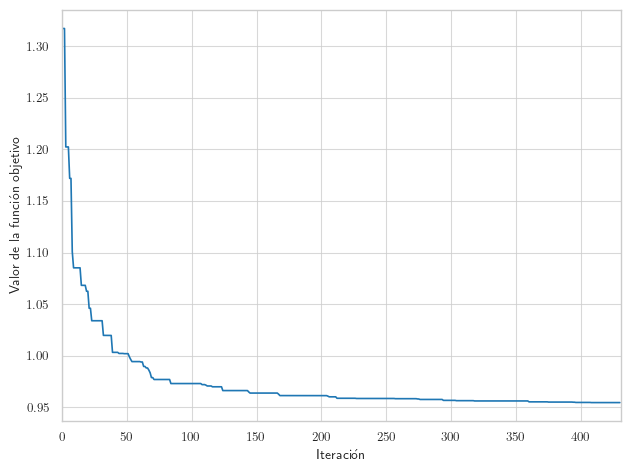

In [ ]:
plt.plot(logger.values)
plt.xlabel('Iteración')
plt.ylabel('Valor de la función objetivo')
# plt.title('Optimización mediante Differential Evolution')
plt.xlim(0, logger.iteration)
plt.tight_layout()  # Ajustar el layout para que no se solapen los elementos
plt.savefig('Figuras/evol_de.pdf', format='pdf')
plt.grid(True)
plt.show()

In [ ]:
F_hib = np.concatenate(([F0], sol_hib.x, [F1]))

population_ga = sol_hib.population[1]
F_ga = np.concatenate (([F0], population_ga, [F1])) 

a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_cat = catenaria(z)

error_ga = np.linalg.norm(F_ga - F_cat)/np.linalg.norm(F_cat)
error_hib = np.linalg.norm(F_hib - F_cat)/np.linalg.norm(F_cat)

print('Error con el DE: ', error_ga)
print('Error con el algoritmo híbrido: ', error_hib)
print('Tiempo de ejecución del algoritmo genético: ', time_hib)

Error con el algoritmo genético:  0.05087177352386374
Error con el algoritmo híbrido:  0.0009554243848131619
Tiempo de ejecución del algoritmo genético:  313.19223856925964


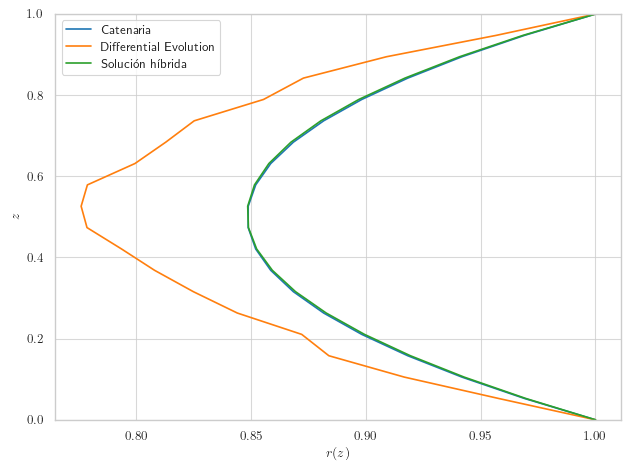

In [ ]:
plt.plot(F_cat, z, label='Catenaria')
plt.plot(F_ga, z, label='Differential Evolution')
plt.plot(F_hib, z, label='Solución híbrida')
plt.legend()
plt.ylabel('$z$')
plt.xlabel('$r(z)$')
# plt.title('Solución calculada con el DE, para $n = {}$'.format(n))
plt.ylim(0, 1)
plt.tight_layout()  # Ajustar el layout para que no se solapen los elementos
plt.savefig('Figuras/comp_de_cat.pdf', format='pdf')
plt.show()

De esta representación, se puede visualizar claramente el efecto del algoritmo considerado. En primer lugar, se calcula una aproximación de la función con una tolerancia deseada, tras la que se corta la iteración de este. De aquí, se toma el individuo con el mejor *fitness* y se refina la solución con un algoritmo de tipo gradiente. 

Este procedimiento sigue siendo más costoso computacionalmente que emplear únicamente el algoritmo tipo gradiente pero, genera una solución de compromiso entre la precisión y rapidez de los algoritmos tipo gradiente y la flexibilidad de los algoritmos heurísticos, consiguiendo así un resultado más óptimo que si se emplease solo uno de los 2 tipos de algoritmos.

## Problema con restricciones de volumen, con soportes iguales.

En el análisis de este apartado se fija el volumen encerrado por la superficie y los planos que contienen a las 2 circunferencias, para ver su efecto sobre la solución del problema.

$V = \int_0^1 F^2 dz$

A continuación, se implementa la expresión siguiente para trasladarla al código de Python.

In [117]:
def vol_func(F):
    Famp = np.concatenate(([F0], F, [F1]))
    n = np.size(Famp)
    delta_z = 1 / (n - 1)

    integral = 0
    for i in range(n-1):
        # calcular el valor de la integral
        integrando = Famp[i]**2
        integral += integrando * delta_z

    return (integral - V_lig)

### Minimzación con un método basado en gradiente

Para poder trabajar comparando las soluciones con las obtenidas para el caso más sencillo, rescatamos los valores de inicialización del problema sin restricciones.

In [118]:
F_0 = 1 
F0 = F_0
F1 = F_0
n = 20
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T

z = np.linspace(0, 1, n)

sol_grad = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Famp_grad = np.concatenate(([F0], sol_grad.x, [F1]))

A fin de que los valores no difieran en exceso del valor obtenido del problema sin restricciones, primero se calcula el volumen de la solución con $F_0 = 1$, con la que se partirá para calcular la solución con restricciones.

In [119]:
V_lig = 0.0 # la ligadura de volumen

vol_no_cons = vol_func(sol_grad.x)
print('Volumen sin restricciones =', vol_no_cons)

Volumen sin restricciones = 0.8095367935945682


Así, se impone la mencionada restricción para observar su influencia en la solución del problema.

In [120]:
cons = ({'type': 'eq', 'fun': vol_func})

In [121]:
V_lig = 0.7

sol_grad_vol05 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol05 = np.concatenate(([F0], sol_grad_vol05.x, [F1]))

In [122]:
V_lig = 1

sol_grad_vol1 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol1 = np.concatenate(([F0], sol_grad_vol1.x, [F1]))

In [123]:
V_lig = 1.5

sol_grad_vol15 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol15 = np.concatenate(([F0], sol_grad_vol15.x, [F1]))

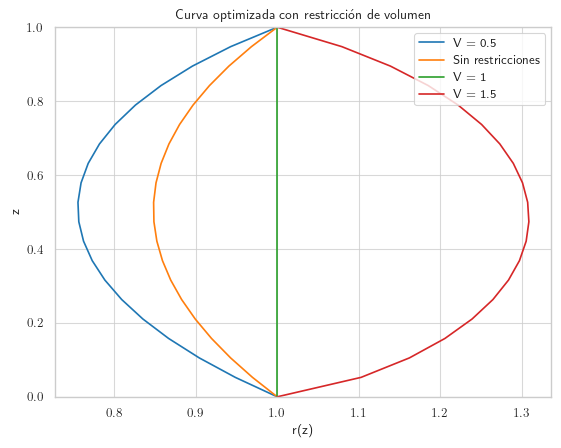

In [124]:
plt.plot(Famp_vol05, z, label='V = 0.7')
plt.plot(Famp_grad, z, label='Sin restricciones')
plt.plot(Famp_vol1, z, label='V = 1')
plt.plot(Famp_vol15, z, label='V = 1.5')
plt.legend()
plt.xlabel('r(z)')
plt.ylabel('z')
# plt.xlim(0, 1.5)
plt.ylim(0, 1)
plt.title('Curva optimizada con restricción de volumen')
plt.grid(True)
plt.show()


Como cabía de esperar, la forma de la solución se modifica al aumentar el valor de la restricción de volumen. Es importante recalcar que esta restricción no puede tomar cualquier valor, ya que si difiere en gran medida del volumen obtenido sin restricciones, la solución puede resultar inexistente o inestable. 

Precisamente, sobre esas posibilidades se va a discutir a continuación. 

In [125]:
V_lig = 2

sol_grad_vol2 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol2 = np.concatenate(([F0], sol_grad_vol2.x, [F1]))

In [126]:
V_lig = 0.4

sol_grad_vol04 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol04 = np.concatenate(([F0], sol_grad_vol04.x, [F1]))

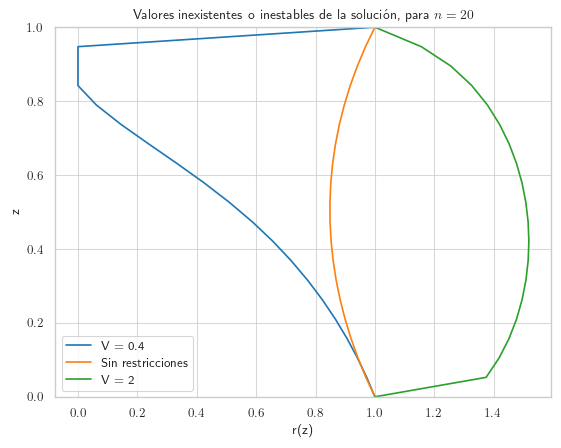

In [127]:
plt.plot(Famp_vol04, z, label='V = 0.4')
plt.plot(Famp_grad, z, label='Sin restricciones')
plt.plot(Famp_vol2, z, label='V = 2')
plt.legend()
plt.xlabel('r(z)')
plt.ylabel('z')
plt.ylim(0, 1)
plt.title('Valores inexistentes o inestables de la solución, para $n = {}$'.format(n))
plt.grid(True)
plt.show()

Se aprecia que, para valores que se alejan en gran medida de la solución sin restricciones, se generan soluciones que, como poco, no tienen sentido físico. 

Cabe pensar que, para los casos más sensibles, pueda existir solución solo que el método no tiene la precisión adecuada para calcularlo. Así, se plantea evaluar el efecto de aumentar el número de puntos, a fin de tener una representación más precisa, caso que se expone a continuación.

In [128]:
F_0 = 1 
F0 = F_0
F1 = F_0
n = 100
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T

z = np.linspace(0, 1, n)

sol_grad = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Famp_grad = np.concatenate(([F0], sol_grad.x, [F1]))

In [129]:
V_lig = 2

sol_grad_vol2 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol2 = np.concatenate(([F0], sol_grad_vol2.x, [F1]))

In [130]:
V_lig = 0.4

sol_grad_vol04 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol04 = np.concatenate(([F0], sol_grad_vol04.x, [F1]))

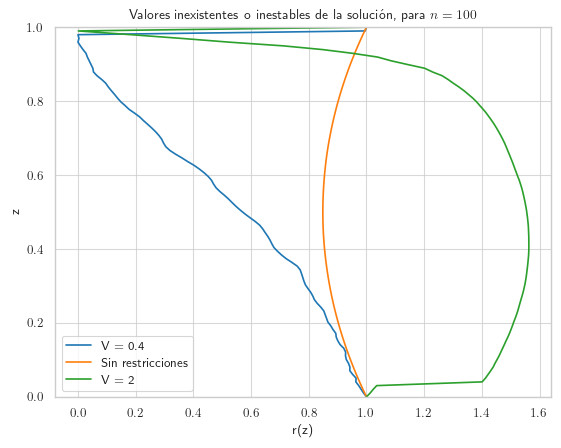

In [131]:
plt.plot(Famp_vol04, z, label='V = 0.4')
plt.plot(Famp_grad, z, label='Sin restricciones')
plt.plot(Famp_vol2, z, label='V = 2')
plt.legend()
plt.xlabel('r(z)')
plt.ylabel('z')
plt.ylim(0, 1)
plt.title('Valores inexistentes o inestables de la solución, para $n = {}$'.format(n))
plt.grid(True)
plt.show()

Tras analizar el resultado de aumentar el número de puntos, se concluye que, efectivamente, para dichos valores de la restricción de volumen, el problema directamente no tiene solución.

#### Influencia de la distribución de puntos.

En este caso, se va a considerar el efecto de considerar diferentes distribuciones de puntos en las que dividir el intervalo del problema. 

Una vez más, se consideran el resto de parámetros idénticos al primer caso de estudio, salvo por el número de puntos $n$, que se va a modificar a fin de apreciar el comportamiento de distintas distribuciones de puntos en los casos más exigentes, es decir, en los casos extremos de $n$ muy grande o muy pequeño. El caso de $n$ intermedio se omite por presentar soluciones casi idénticas en todos los casos.

##### Caso de $n$ muy pequeño.

En primer lugar, se considera la restricción de volumen que generaría un cilindro recto. En este caso, que se traduce en $V = 1.0$.

In [132]:
n = 20
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
V_lig = 1.0

# planteamos la función que calcula el área tomando delta_z como un array definido anteriormente
def area_distrib(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)

    integral = 0
    for i in range(n-1):
        # calcular la derivada
        F_der = (Famp[i+1] - Famp[i]) / delta_z[i] # esquema adelantado para el cálculo de la derivada
        # calcular el valor de la integral
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z[i]

    return integral

In [133]:
def vol_distrib(F):
    Famp = np.concatenate(([F0], F, [F1]))
    n = np.size(Famp)
    # delta_z = 1 / (n - 1)

    integral = 0
    for i in range(n-1):
        # calcular el valor de la integral
        integrando = Famp[i]**2
        integral += integrando * delta_z[i]

    return (integral - V_lig)

# V_lig = 1.0
cons = ({'type': 'eq', 'fun': vol_distrib})

- Distribución de puntos **equiespaciada**

In [134]:
zeq = np.linspace(0, 1, n)
delta_z = np.diff(zeq)
sol_gradeq = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_eq = np.concatenate(([F0], sol_gradeq.x, [F1]))
print('Volumen de la solución equiespaciada:', vol_distrib(sol_gradeq.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_cateq = catenaria(zeq)
# error_eq = np.linalg.norm(Famp_eq - F_cateq)/np.linalg.norm(F_cateq)
# print('El error para distribución equiespaciada es:', error_eq)

Volumen de la solución equiespaciada: 1.0


- Distribución de puntos según un esquema de **ceros de Chebyshev**: $z_i = \cos{ \left( \frac{\frac{\pi}{2} + \pi i}{n + 1} \right) }, \quad i = 0, \dots , n$

In [135]:
def chebyshev_zeros(a, b, n):
    cheb_zeros = np.cos((2 * np.arange(1, n+1) - 1) * np.pi / (2 * n))
    mapped_zeros = 0.5 * (b - a) * (cheb_zeros + 1) + a
    sorted_zeros = np.sort(mapped_zeros) # porque los calcula en orden decreciente
    return sorted_zeros

zchebz = chebyshev_zeros(0, 1, n)
delta_z = np.diff(zchebz)
sol_gradchebz = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_chebz = np.concatenate(([F0], sol_gradchebz.x, [F1]))
print('Volumen de la solución con ceros de Chebyshev:', vol_distrib(sol_gradchebz.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catchebz = catenaria(zchebz)
# error_chebz = np.linalg.norm(Famp_chebz - F_catchebz)/np.linalg.norm(F_catchebz)
# print('El error para los nodos de Chebyshev es:', error_chebz)

Volumen de la solución con ceros de Chebyshev: 1.0000001157114373


- Distribución de puntos según un esquema de **extremos de Chebyshev**: $z_i =  \cos{ \left( \frac{\pi i}{n} \right) }, \quad i = 0, \dots , n$

In [136]:
def chebyshev_extremes(a, b, n):
    cheb_extremes = np.cos(np.arange(n) * np.pi / (n - 1))
    mapped_extremes = 0.5 * (b - a) * (cheb_extremes + 1) + a
    sorted_extremes = np.sort(mapped_extremes)
    return sorted_extremes

zchebe = chebyshev_extremes(0, 1, n)
delta_z = np.diff(zchebe)
sol_gradchebe = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_chebe = np.concatenate(([F0], sol_gradchebe.x, [F1]))
print('Volumen de la solución con extremos de Chebyshev:', vol_distrib(sol_gradchebe.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catchebe = catenaria(zchebe)
# error_chebe = np.linalg.norm(Famp_chebe - F_catchebe)/np.linalg.norm(F_catchebe)
# print('El error para los extremos de Chebyshev es:', error_chebe)

Volumen de la solución con extremos de Chebyshev: 1.0000000024621918


- Distribución que **concentra puntos en el centro del intervalo**. 

Simplemente en la mitad central del intervalo se concentran puntos a la mitad de distancia que en los extremos.

In [137]:
def concentrar_centro(a, b, n):
  n1 = n // 6
  n2 = n - 2 * n1
  n3 = n - n1 - n2

  x1 = np.linspace(a, a + (b - a) / 4, n1, endpoint=False)
  x2 = np.linspace(a + (b - a) / 4, a + 3 * (b - a) / 4, n2, endpoint=False)
  x3 = np.linspace(a + 3 * (b - a) / 4, b, n3)

  x = np.concatenate((x1, x2, x3))
  return x

zcent = concentrar_centro(0, 1, n)
delta_z = np.diff(zcent)
sol_gradcent = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
print('Volumen de la solución concentrada en el centro:', vol_distrib(sol_gradcent.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catcent = catenaria(zcent)
# error_cent = np.linalg.norm(Famp_cent - F_catcent)/np.linalg.norm(F_catcent)
# print('El error para la distribución de puntos concentrada en el centro es:', error_cent)

Volumen de la solución concentrada en el centro: 1.0000000405984284


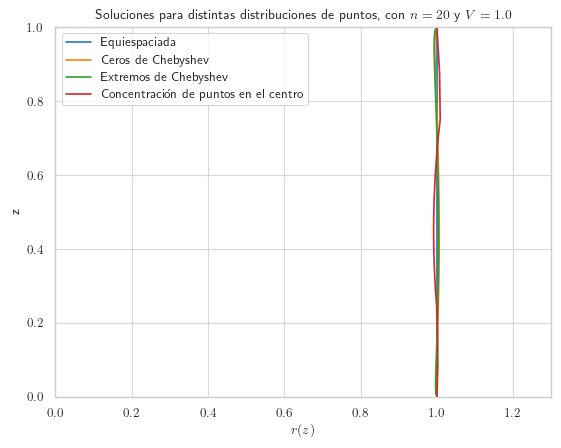

In [138]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(Famp_cent, zcent, label='Concentración de puntos en el centro')
# plt.plot(F_cateq, zeq, label='Catenaria')
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
plt.xlim(0, 1.3)
plt.title('Soluciones para distintas distribuciones de puntos, con $n = {}$ y $V = {}$'.format(n, V_lig))
plt.legend()
plt.grid(True)
plt.show()

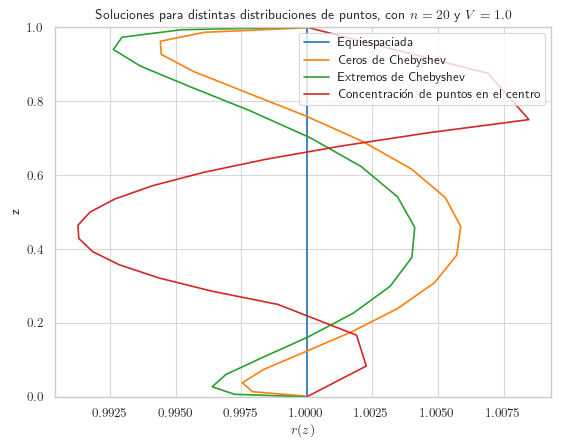

In [139]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(Famp_cent, zcent, label='Concentración de puntos en el centro')
# plt.plot(F_cateq, zeq, label='Catenaria')
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
plt.title('Soluciones para distintas distribuciones de puntos, con $n = {}$ y $V = {}$'.format(n, V_lig))
plt.legend()
plt.grid(True)
plt.show()

A primera vista, todas las soluciones son extremadamente similares, por lo que se pueden considerar todas igual de válidas. Sin embargo, al ampliar y observar la solución de una forma más cercana, se aprecia que la única que cumple la restricción de $V = 1$ y además se corresponde con la solución esperada es la equiespaciada. 

<font color='red'> NO SÉ EXPLICAR POR QUÉ ESO ES ASÍ </font>

Por otro lado, ahora se va a considerar la restricción de volumen de $V = 1.3$, es decir, que la burbuja sobresalga y el volumen sea mayor que el correspondiente a un cilindro recto. 

In [140]:
n = 20
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
V_lig = 1.3

# planteamos la función que calcula el área tomando delta_z como un array definido anteriormente
def area_distrib(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)

    integral = 0
    for i in range(n-1):
        # calcular la derivada
        F_der = (Famp[i+1] - Famp[i]) / delta_z[i] # esquema adelantado para el cálculo de la derivada
        # calcular el valor de la integral
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z[i]

    return integral

In [141]:
def vol_distrib(F):
    Famp = np.concatenate(([F0], F, [F1]))
    n = np.size(Famp)
    # delta_z = 1 / (n - 1)

    integral = 0
    for i in range(n-1):
        # calcular el valor de la integral
        integrando = Famp[i]**2
        integral += integrando * delta_z[i]

    return (integral - V_lig)

# V_lig = 1.0
cons = ({'type': 'eq', 'fun': vol_distrib})

- Distribución de puntos **equiespaciada**

In [142]:
zeq = np.linspace(0, 1, n)
delta_z = np.diff(zeq)
sol_gradeq = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_eq = np.concatenate(([F0], sol_gradeq.x, [F1]))
print('Volumen de la solución equiespaciada:', vol_distrib(sol_gradeq.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_cateq = catenaria(zeq)
# error_eq = np.linalg.norm(Famp_eq - F_cateq)/np.linalg.norm(F_cateq)
# print('El error para distribución equiespaciada es:', error_eq)

Volumen de la solución equiespaciada: 1.300000020521231


- Distribución de puntos según un esquema de **ceros de Chebyshev**: $z_i = \cos{ \left( \frac{\frac{\pi}{2} + \pi i}{n + 1} \right) }, \quad i = 0, \dots , n$

In [143]:
def chebyshev_zeros(a, b, n):
    cheb_zeros = np.cos((2 * np.arange(1, n+1) - 1) * np.pi / (2 * n))
    mapped_zeros = 0.5 * (b - a) * (cheb_zeros + 1) + a
    sorted_zeros = np.sort(mapped_zeros) # porque los calcula en orden decreciente
    return sorted_zeros

zchebz = chebyshev_zeros(0, 1, n)
delta_z = np.diff(zchebz)
sol_gradchebz = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_chebz = np.concatenate(([F0], sol_gradchebz.x, [F1]))
print('Volumen de la solución con ceros de Chebyshev:', vol_distrib(sol_gradchebz.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catchebz = catenaria(zchebz)
# error_chebz = np.linalg.norm(Famp_chebz - F_catchebz)/np.linalg.norm(F_catchebz)
# print('El error para los nodos de Chebyshev es:', error_chebz)

Volumen de la solución con ceros de Chebyshev: 1.3000001343495755


- Distribución de puntos según un esquema de **extremos de Chebyshev**: $z_i =  \cos{ \left( \frac{\pi i}{n} \right) }, \quad i = 0, \dots , n$

In [144]:
def chebyshev_extremes(a, b, n):
    cheb_extremes = np.cos(np.arange(n) * np.pi / (n - 1))
    mapped_extremes = 0.5 * (b - a) * (cheb_extremes + 1) + a
    sorted_extremes = np.sort(mapped_extremes)
    return sorted_extremes

zchebe = chebyshev_extremes(0, 1, n)
delta_z = np.diff(zchebe)
sol_gradchebe = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_chebe = np.concatenate(([F0], sol_gradchebe.x, [F1]))
print('Volumen de la solución con extremos de Chebyshev:', vol_distrib(sol_gradchebe.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catchebe = catenaria(zchebe)
# error_chebe = np.linalg.norm(Famp_chebe - F_catchebe)/np.linalg.norm(F_catchebe)
# print('El error para los extremos de Chebyshev es:', error_chebe)

Volumen de la solución con extremos de Chebyshev: 1.3000002438497287


- Distribución que **concentra puntos en el centro del intervalo**. 

Simplemente en la mitad central del intervalo se concentran puntos a la mitad de distancia que en los extremos.

In [145]:
def concentrar_centro(a, b, n):
  n1 = n // 6
  n2 = n - 2 * n1
  n3 = n - n1 - n2

  x1 = np.linspace(a, a + (b - a) / 4, n1, endpoint=False)
  x2 = np.linspace(a + (b - a) / 4, a + 3 * (b - a) / 4, n2, endpoint=False)
  x3 = np.linspace(a + 3 * (b - a) / 4, b, n3)

  x = np.concatenate((x1, x2, x3))
  return x

zcent = concentrar_centro(0, 1, n)
delta_z = np.diff(zcent)
sol_gradcent = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
print('Volumen de la solución concentrada en el centro:', vol_distrib(sol_gradcent.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catcent = catenaria(zcent)
# error_cent = np.linalg.norm(Famp_cent - F_catcent)/np.linalg.norm(F_catcent)
# print('El error para la distribución de puntos concentrada en el centro es:', error_cent)

Volumen de la solución concentrada en el centro: 1.3000000161905994


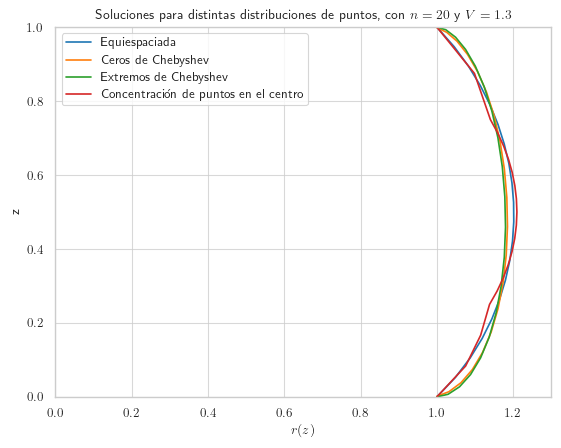

In [146]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(Famp_cent, zcent, label='Concentración de puntos en el centro')
# plt.plot(F_cateq, zeq, label='Catenaria')
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
plt.xlim(0, 1.3)
plt.title('Soluciones para distintas distribuciones de puntos, con $n = {}$ y $V = {}$'.format(n, V_lig))
plt.legend()
plt.grid(True)
plt.show()

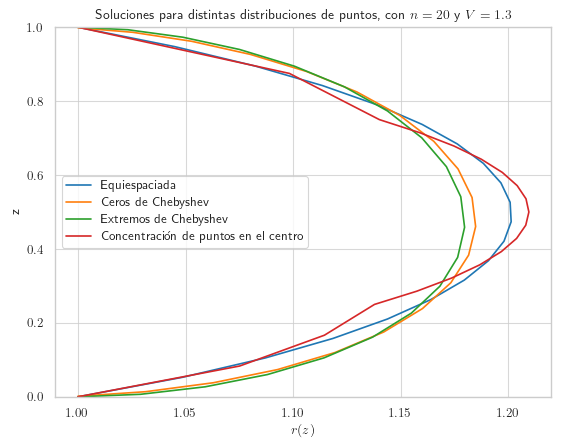

In [147]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(Famp_cent, zcent, label='Concentración de puntos en el centro')
# plt.plot(F_cateq, zeq, label='Catenaria')
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
plt.title('Soluciones para distintas distribuciones de puntos, con $n = {}$ y $V = {}$'.format(n, V_lig))
plt.legend()
plt.grid(True)
plt.show()

Para este caso, también se observa que se tienen soluciones muy dispares en todos los métodos considerados. Salvo la producida por la distribución que concentra más puntos en el centro, todas parecen plausibles y es difícil discernir cual de ellas es la solución adecuada.

##### Caso de $n$ muy grande.

In [148]:
n = 200
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
V_lig = 1.0

# planteamos la función que calcula el área tomando delta_z como un array definido anteriormente
def area_distrib(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)
    # delta_z = 1 / (n - 1)

    integral = 0
    for i in range(n-1):
        # calcular la derivada
        F_der = (Famp[i+1] - Famp[i]) / delta_z[i] # esquema adelantado para el cálculo de la derivada
        # calcular el valor de la integral
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z[i]

    return integral

- Distribución de puntos **equiespaciada**

In [149]:
zeq = np.linspace(0, 1, n)
delta_z = np.diff(zeq)
sol_gradeq = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_eq = np.concatenate(([F0], sol_gradeq.x, [F1]))
print('Volumen de la solución equiespaciada:', vol_distrib(sol_gradeq.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_cateq = catenaria(zeq)
# error_eq = np.linalg.norm(Famp_eq - F_cateq)
# print('El error para distribución equiespaciada es:', error_eq)

Volumen de la solución equiespaciada: 1.0


- Distribución de puntos según un esquema de **ceros de Chebyshev**

In [150]:
def chebyshev_zeros(a, b, n):
    cheb_zeros = np.cos((2 * np.arange(1, n+1) - 1) * np.pi / (2 * n))
    mapped_zeros = 0.5 * (b - a) * (cheb_zeros + 1) + a
    sorted_zeros = np.sort(mapped_zeros) # porque los calcula en orden decreciente
    return sorted_zeros

zchebz = chebyshev_zeros(0, 1, n)
delta_z = np.diff(zchebz)
sol_gradchebz = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_chebz = np.concatenate(([F0], sol_gradchebz.x, [F1]))
print('Volumen de la solución con ceros de Chebyshev:', vol_distrib(sol_gradchebz.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catchebz = catenaria(zchebz)
# error_chebz = np.linalg.norm(Famp_chebz - F_catchebz)
# print('El error para los nodos de Chebyshev es:', error_chebz)

Volumen de la solución con ceros de Chebyshev: 0.9999836287967387


- Distribución de puntos según un esquema de **extremos de Chebyshev**

In [151]:
def chebyshev_extremes(a, b, n):
    cheb_extremes = np.cos(np.arange(n) * np.pi / (n - 1))
    mapped_extremes = 0.5 * (b - a) * (cheb_extremes + 1) + a
    sorted_extremes = np.sort(mapped_extremes)
    return sorted_extremes

zchebe = chebyshev_extremes(0, 1, n)
delta_z = np.diff(zchebe)
sol_gradchebe = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_chebe = np.concatenate(([F0], sol_gradchebe.x, [F1]))
print('Volumen de la solución con extremos de Chebyshev:', vol_distrib(sol_gradchebe.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catchebe = catenaria(zchebe)
# error_chebe = np.linalg.norm(Famp_chebe - F_catchebe)
# print('El error para los extremos de Chebyshev es:', error_chebe)

Volumen de la solución con extremos de Chebyshev: 1.0000002833992985


- Distribución que **concentra puntos en el centro del intervalo**. 

Simplemente en la mitad central del intervalo se concentran puntos a la mitad de distancia que en los extremos.

In [152]:
zcent = concentrar_centro(0, 1, n)
delta_z = np.diff(zcent)
sol_gradcent = minimize(area_distrib, F_init, constraints=cons, bounds=bounds, method='SLSQP')
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
print('Volumen de la solución con concentración en el centro:', vol_distrib(sol_gradcent.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catcent = catenaria(zcent)
# error_cent = np.linalg.norm(Famp_cent - F_catcent)/np.linalg.norm(F_catcent)
# print('El error para la distribución de puntos concentrada en el centro es:', error_cent)

Volumen de la solución con concentración en el centro: 1.0


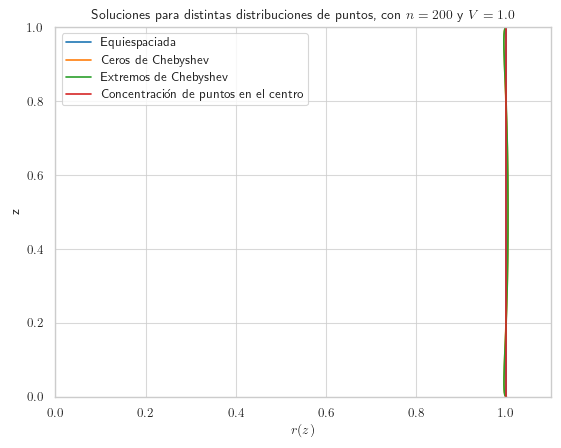

In [153]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(Famp_cent, zcent, label='Concentración de puntos en el centro')
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
plt.xlim(0, 1.1)
plt.title('Soluciones para distintas distribuciones de puntos, con $n = {}$ y $V = {}$'.format(n, V_lig))
plt.legend()
plt.grid(True)
plt.show()

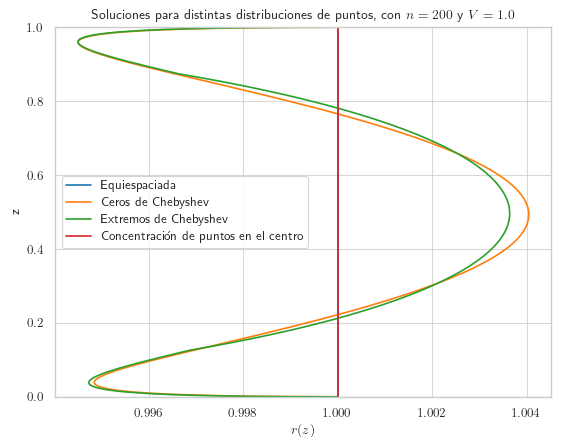

In [154]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(Famp_cent, zcent, label='Concentración de puntos en el centro')
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
# plt.xlim(0, 1.1)
plt.title('Soluciones para distintas distribuciones de puntos, con $n = {}$ y $V = {}$'.format(n, V_lig))
plt.legend()
plt.grid(True)
plt.show()

Aquí, una vez más, las 4 soluciones son esencialmente idénticas, pero, al aumentar la resolución, se aprecia claramente el mismo fenómeno que se observaba con pocos puntos. 

Una vez más, se va a considerar el problema con una condición de volumen superior a la del cilindro recto, para observar como se comporta la solución en el caso que se consideran tantos puntos.

In [155]:
n = 200
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T
V_lig = 1.3

- Distribución de puntos **equiespaciada**

In [156]:
zeq = np.linspace(0, 1, n)
delta_z = np.diff(zeq)
sol_gradeq = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_eq = np.concatenate(([F0], sol_gradeq.x, [F1]))
print('Volumen de la solución equiespaciada:', vol_distrib(sol_gradeq.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_cateq = catenaria(zeq)
# error_eq = np.linalg.norm(Famp_eq - F_cateq)/np.linalg.norm(F_cateq)
# print('El error para distribución equiespaciada es:', error_eq)

Volumen de la solución equiespaciada: 1.3086055048365264


- Distribución de puntos según un esquema de **ceros de Chebyshev**: $z_i = \cos{ \left( \frac{\frac{\pi}{2} + \pi i}{n + 1} \right) }, \quad i = 0, \dots , n$

In [157]:
def chebyshev_zeros(a, b, n):
    cheb_zeros = np.cos((2 * np.arange(1, n+1) - 1) * np.pi / (2 * n))
    mapped_zeros = 0.5 * (b - a) * (cheb_zeros + 1) + a
    sorted_zeros = np.sort(mapped_zeros) # porque los calcula en orden decreciente
    return sorted_zeros

zchebz = chebyshev_zeros(0, 1, n)
delta_z = np.diff(zchebz)
sol_gradchebz = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_chebz = np.concatenate(([F0], sol_gradchebz.x, [F1]))
print('Volumen de la solución con ceros de Chebyshev:', vol_distrib(sol_gradchebz.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catchebz = catenaria(zchebz)
# error_chebz = np.linalg.norm(Famp_chebz - F_catchebz)/np.linalg.norm(F_catchebz)
# print('El error para los nodos de Chebyshev es:', error_chebz)

Volumen de la solución con ceros de Chebyshev: 1.3103552124176376


- Distribución de puntos según un esquema de **extremos de Chebyshev**: $z_i =  \cos{ \left( \frac{\pi i}{n} \right) }, \quad i = 0, \dots , n$

In [158]:
def chebyshev_extremes(a, b, n):
    cheb_extremes = np.cos(np.arange(n) * np.pi / (n - 1))
    mapped_extremes = 0.5 * (b - a) * (cheb_extremes + 1) + a
    sorted_extremes = np.sort(mapped_extremes)
    return sorted_extremes

zchebe = chebyshev_extremes(0, 1, n)
delta_z = np.diff(zchebe)
sol_gradchebe = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_chebe = np.concatenate(([F0], sol_gradchebe.x, [F1]))
print('Volumen de la solución con extremos de Chebyshev:', vol_distrib(sol_gradchebe.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catchebe = catenaria(zchebe)
# error_chebe = np.linalg.norm(Famp_chebe - F_catchebe)/np.linalg.norm(F_catchebe)
# print('El error para los extremos de Chebyshev es:', error_chebe)

Volumen de la solución con extremos de Chebyshev: 1.3104656563827153


- Distribución que **concentra puntos en el centro del intervalo**. 

Simplemente en la mitad central del intervalo se concentran puntos a la mitad de distancia que en los extremos.

In [159]:
def concentrar_centro(a, b, n):
  n1 = n // 6
  n2 = n - 2 * n1
  n3 = n - n1 - n2

  x1 = np.linspace(a, a + (b - a) / 4, n1, endpoint=False)
  x2 = np.linspace(a + (b - a) / 4, a + 3 * (b - a) / 4, n2, endpoint=False)
  x3 = np.linspace(a + 3 * (b - a) / 4, b, n3)

  x = np.concatenate((x1, x2, x3))
  return x

zcent = concentrar_centro(0, 1, n)
delta_z = np.diff(zcent)
sol_gradcent = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
print('Volumen de la solución concentrada en el centro:', vol_distrib(sol_gradcent.x) + V_lig)
# a_sol, k_sol = fsolve(params_catenaria, initial_guess)
# F_catcent = catenaria(zcent)
# error_cent = np.linalg.norm(Famp_cent - F_catcent)/np.linalg.norm(F_catcent)
# print('El error para la distribución de puntos concentrada en el centro es:', error_cent)

Volumen de la solución concentrada en el centro: 1.3096553430264293


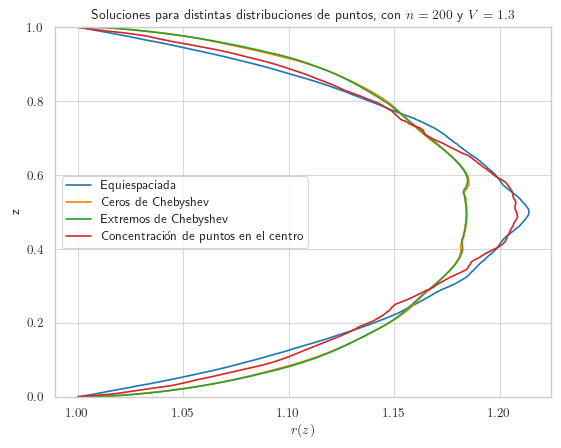

In [160]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(Famp_cent, zcent, label='Concentración de puntos en el centro')
# plt.plot(F_cateq, zeq, label='Catenaria')
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
plt.title('Soluciones para distintas distribuciones de puntos, con $n = {}$ y $V = {}$'.format(n, V_lig))
plt.legend()
plt.grid(True)
plt.show()

Para este caso, se observa que ninguna de los esquemas empleados proporciona una solución convincente. Por esto, se puede deducir que, la introducción de complicaciones en el cálculo de la solución (como pueden ser las restricciones), junto al cálculo de la solución para una cantidad importante de puntos, como se observa en el apartado anterior, dificulta mucho el proceso de optimización, denotando la necesidad de métodos más sofisticados que se escapan de el análisis de este trabajo. 

### Minimización con un método heurístico (Differential evolution)

In [161]:
F_0 = 1
n = 10
z = np.linspace(0, 1, n)
V_lig = 1

bounds = [(F_0-0.5, F_0+0.5) for _ in range(n-2)] 

tol_vol = 1e-1#3 # tolerancia con la restricción
cons_ga = NonlinearConstraint(vol_func, -tol_vol, tol_vol)

Iteración: 1, Valor de la función: 1.395591641097558
Iteración: 2, Valor de la función: 1.395591641097558
Iteración: 3, Valor de la función: 1.2025687105237515
Iteración: 4, Valor de la función: 1.074220754127054
Iteración: 5, Valor de la función: 1.074220754127054
Iteración: 6, Valor de la función: 1.074220754127054
Iteración: 7, Valor de la función: 1.064032366138938
Iteración: 8, Valor de la función: 1.064032366138938
Iteración: 9, Valor de la función: 1.064032366138938
Iteración: 10, Valor de la función: 1.064032366138938
Iteración: 11, Valor de la función: 1.0319812595385387
Iteración: 12, Valor de la función: 1.0089929988421444
Iteración: 13, Valor de la función: 1.0089929988421444
Iteración: 14, Valor de la función: 0.9917766536115479
Iteración: 15, Valor de la función: 0.9917766536115479
Iteración: 16, Valor de la función: 0.9737782412189429
Iteración: 17, Valor de la función: 0.9737782412189429
Iteración: 18, Valor de la función: 0.9737782412189429
Iteración: 19, Valor de la f

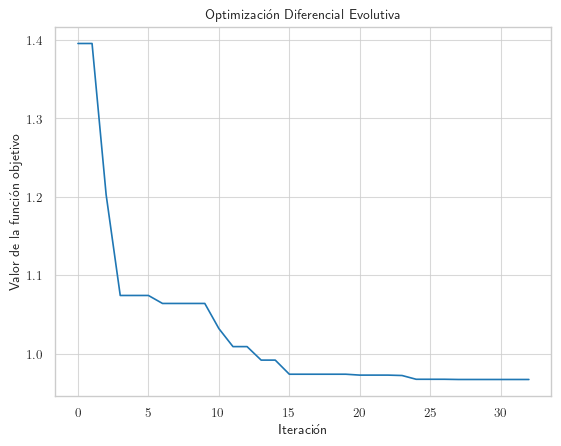

In [162]:

# Ejecutar la optimización con registro de valores
result = differential_evolution(
    area_func, 
    bounds=bounds, 
    constraints=cons_ga, 
    maxiter=100000, 
    popsize=4*n, 
    mutation=(0.5, 1), 
    recombination=0.7, 
    strategy='best1bin', 
    tol=0.01, 
    # disp=True,
    callback=logger
)

# Graficar los resultados
plt.plot(logger.values)
plt.xlabel('Iteración')
plt.ylabel('Valor de la función objetivo')
plt.title('Optimización Diferencial Evolutiva')
plt.show()

## Problema sin restricciones, con soportes de diferente tamaño

A continuación, se considera el caso en el que ambos soportes no son iguales, si no que las condiciones de contorno impuestas anteriormente se sustituyen por las siguientes:

$F(0) = F_0 - \varepsilon$

$F(1) = F_0 + \varepsilon$

Con esto, el problema pierde su simetría, por lo que se presume que aumentará la potencia de cálculo requerida para encontrar una solución. A continuación, se van a discutir los efectos de este cambio en las soluciones del problema.

In [ ]:
F_0 = 1
eps = 0.05
F0 = F_0 - eps
F1 = F_0 + eps

n = 50
z = np.linspace(0, 1, n)

F_init = np.linspace(F0, F1, n-2)

lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T

In [ ]:
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_cat = catenaria(z)

### Minimización con un método basado en gradiente.

In [ ]:
sol_grad_sop = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Famp_sop = np.concatenate(([F0], sol_grad_sop.x, [F1]))
error_sop = np.linalg.norm(Famp_sop - F_cat)/np.linalg.norm(F_cat)
print('El error para la solucion estándar es:', error_sop)

El error para la solucion estándar es: 0.0010616198301616397


<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ismag\AppData\Local\Temp\ipykernel_19084\1267443143.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Curva optimizada con soportes de diferente tamaño, para $ \epsilon = {}$'.format(eps))


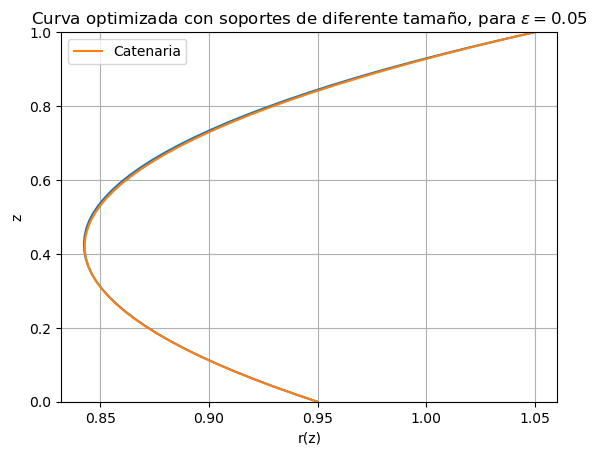

In [ ]:
plt.plot(Famp_sop, z)
plt.plot(F_cat, z, label='Catenaria')
plt.legend()
plt.xlabel('r(z)')
plt.ylabel('z')
plt.ylim(0, 1)
plt.title('Curva optimizada con soportes de diferente tamaño, para $ \epsilon = {}$'.format(eps))
plt.grid(True)
plt.show()

#### Influencia de la diferencia entre los soportes, $\varepsilon$

In [ ]:
eps = 0.1

#### Influencia de la distribución de puntos.

En este caso, se va a considerar el efecto de considerar diferentes distribuciones de puntos en las que dividir el intervalo del problema. 

Una vez más, se consideran el resto de parámetros idénticos al primer caso de estudio, salvo por el número de puntos $n$, que se va a modificar a fin de apreciar el comportamiento de distintas distribuciones de puntos en los casos más exigentes, es decir, en los casos extremos de $n$ muy grande o muy pequeño. El caso de $n$ intermedio se omite por presentar soluciones casi idénticas en todos los casos.

In [ ]:
F_0 = 1
eps = 0.1
F0 = F_0 - eps
F1 = F_0 + eps

##### Caso de $n$ muy pequeño.

In [ ]:
n = 20
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T

# planteamos la función que calcula el área tomando delta_z como un array definido anteriormente
def area_distrib(F):
    Famp = np.append(np.array([F0]), np.append(F, F1))
    n = np.size(Famp)

    integral = 0
    for i in range(n-1):
        # calcular la derivada
        F_der = (Famp[i+1] - Famp[i]) / delta_z[i] # esquema adelantado para el cálculo de la derivada
        # calcular el valor de la integral
        integrando = Famp[i] * np.sqrt(1 + F_der**2)
        integral += integrando * delta_z[i]

    return integral

- Distribución de puntos **equiespaciada**

In [ ]:
zeq = np.linspace(0, 1, n)
delta_z = np.diff(zeq)
sol_gradeq = minimize(area_func, F_init, method='SLSQP', bounds=bounds)
Famp_eq = np.concatenate(([F0], sol_gradeq.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_cateq = catenaria(zeq)
error_eq = np.linalg.norm(Famp_eq - F_cateq)/np.linalg.norm(F_cateq)
print('El error para distribución equiespaciada es:', error_eq)

El error para distribución equiespaciada es: 0.0035191060883840814


- Distribución de puntos según un esquema de **ceros de Chebyshev**: $z_i = \cos{ \left( \frac{\frac{\pi}{2} + \pi i}{n + 1} \right) }, \quad i = 0, \dots , n$

In [ ]:
def chebyshev_zeros(a, b, n):
    cheb_zeros = np.cos((2 * np.arange(1, n+1) - 1) * np.pi / (2 * n))
    mapped_zeros = 0.5 * (b - a) * (cheb_zeros + 1) + a
    sorted_zeros = np.sort(mapped_zeros) # porque los calcula en orden decreciente
    return sorted_zeros

zchebz = chebyshev_zeros(0, 1, n)
delta_z = np.diff(zchebz)
sol_gradchebz = minimize(area_func, F_init, method='SLSQP', bounds=bounds)
Famp_chebz = np.concatenate(([F0], sol_gradchebz.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catchebz = catenaria(zchebz)
error_chebz = np.linalg.norm(Famp_chebz - F_catchebz)/np.linalg.norm(F_catchebz)
print('El error para los nodos de Chebyshev es:', error_chebz)

El error para los nodos de Chebyshev es: 0.03394472870761714


- Distribución de puntos según un esquema de **extremos de Chebyshev**: $z_i =  \cos{ \left( \frac{\pi i}{n} \right) }, \quad i = 0, \dots , n$

In [ ]:
def chebyshev_extremes(a, b, n):
    cheb_extremes = np.cos(np.arange(n) * np.pi / (n - 1))
    mapped_extremes = 0.5 * (b - a) * (cheb_extremes + 1) + a
    sorted_extremes = np.sort(mapped_extremes)
    return sorted_extremes

zchebe = chebyshev_extremes(0, 1, n)
delta_z = np.diff(zchebe)
sol_gradchebe = minimize(area_func, F_init, method='SLSQP', bounds=bounds)
Famp_chebe = np.concatenate(([F0], sol_gradchebe.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catchebe = catenaria(zchebe)
error_chebe = np.linalg.norm(Famp_chebe - F_catchebe)/np.linalg.norm(F_catchebe)
print('El error para los extremos de Chebyshev es:', error_chebe)

El error para los extremos de Chebyshev es: 0.03938968250050415


- Distribución que **concentra puntos en el centro del intervalo**. 

Simplemente en la mitad central del intervalo se concentran puntos a la mitad de distancia que en los extremos.

In [ ]:
def concentrar_centro(a, b, n):
  n1 = n // 6
  n2 = n - 2 * n1
  n3 = n - n1 - n2

  x1 = np.linspace(a, a + (b - a) / 4, n1, endpoint=False)
  x2 = np.linspace(a + (b - a) / 4, a + 3 * (b - a) / 4, n2, endpoint=False)
  x3 = np.linspace(a + 3 * (b - a) / 4, b, n3)

  x = np.concatenate((x1, x2, x3))
  return x

zcent = concentrar_centro(0, 1, n)
delta_z = np.diff(zcent)
sol_gradcent = minimize(area_func, F_init, method='SLSQP', bounds=bounds)
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catcent = catenaria(zcent)
error_cent = np.linalg.norm(Famp_cent - F_catcent)/np.linalg.norm(F_catcent)
print('El error para la distribución de puntos concentrada en el centro es:', error_cent)

El error para la distribución de puntos concentrada en el centro es: 0.035411978379535095


<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ismag\AppData\Local\Temp\ipykernel_25744\1885633864.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Soluciones para distintas distribuciones de puntos y soportes distintos, con $n = {}$ y $\epsilon = {}$'.format(n, eps))


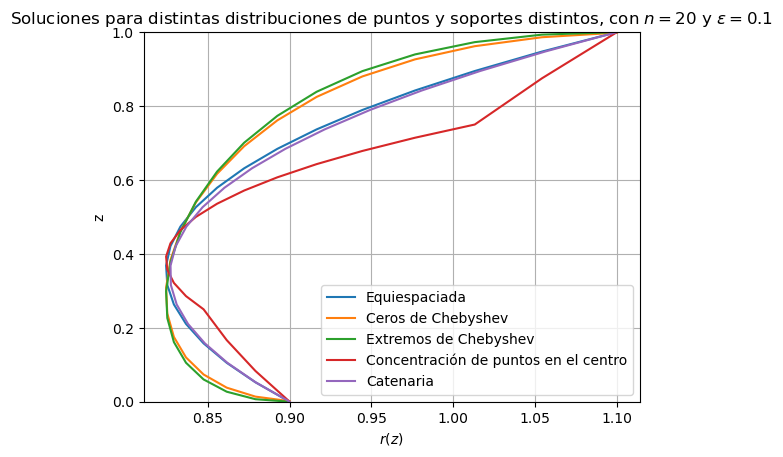

In [ ]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(Famp_cent, zcent, label='Concentración de puntos en el centro')
plt.plot(F_cateq, zeq, label='Catenaria')
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
# plt.xlim(0, 1.3)
plt.title('Soluciones para distintas distribuciones de puntos y soportes distintos, con $n = {}$ y $\epsilon = {}$'.format(n, eps))
plt.legend()
plt.grid(True)
plt.show()

A primera vista, todas las soluciones son extremadamente similares, por lo que se pueden considerar todas igual de válidas. Sin embargo, al ampliar y observar la solución de una forma más cercana, se aprecia que la única que cumple la restricción de $V = 1$ y además se corresponde con la solución esperada es la equiespaciada. 

<font color='red'> NO SÉ EXPLICAR POR QUÉ ESO ES ASÍ </font>

##### Caso de $n$ muy grande.

In [ ]:
n = 200
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T

- Distribución de puntos **equiespaciada**

In [ ]:
zeq = np.linspace(0, 1, n)
delta_z = np.diff(zeq)
sol_gradeq = minimize(area_func, F_init, method='SLSQP', bounds=bounds)
Famp_eq = np.concatenate(([F0], sol_gradeq.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_cateq = catenaria(zeq)
error_eq = np.linalg.norm(Famp_eq - F_cateq)/np.linalg.norm(F_cateq)
print('El error para distribución equiespaciada es:', error_eq)

El error para distribución equiespaciada es: 0.0014236405509258432


- Distribución de puntos según un esquema de **ceros de Chebyshev**: $z_i = \cos{ \left( \frac{\frac{\pi}{2} + \pi i}{n + 1} \right) }, \quad i = 0, \dots , n$

In [ ]:
zchebz = chebyshev_zeros(0, 1, n)
delta_z = np.diff(zchebz)
sol_gradchebz = minimize(area_func, F_init, method='SLSQP', bounds=bounds)
Famp_chebz = np.concatenate(([F0], sol_gradchebz.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catchebz = catenaria(zchebz)
error_chebz = np.linalg.norm(Famp_chebz - F_catchebz)/np.linalg.norm(F_catchebz)
print('El error para los nodos de Chebyshev es:', error_chebz)

El error para los nodos de Chebyshev es: 0.03624382262712144


- Distribución de puntos según un esquema de **extremos de Chebyshev**: $z_i =  \cos{ \left( \frac{\pi i}{n} \right) }, \quad i = 0, \dots , n$

In [ ]:
zchebe = chebyshev_extremes(0, 1, n)
delta_z = np.diff(zchebe)
sol_gradchebe = minimize(area_func, F_init, method='SLSQP', bounds=bounds)
Famp_chebe = np.concatenate(([F0], sol_gradchebe.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catchebe = catenaria(zchebe)
error_chebe = np.linalg.norm(Famp_chebe - F_catchebe)/np.linalg.norm(F_catchebe)
print('El error para los extremos de Chebyshev es:', error_chebe)

El error para los extremos de Chebyshev es: 0.038417010836753175


- Distribución que **concentra puntos en el centro del intervalo**. 

Simplemente en la mitad central del intervalo se concentran puntos a la mitad de distancia que en los extremos.

In [ ]:
zcent = concentrar_centro(0, 1, n)
delta_z = np.diff(zcent)
sol_gradcent = minimize(area_func, F_init, method='SLSQP', bounds=bounds)
Famp_cent = np.concatenate(([F0], sol_gradcent.x, [F1]))
a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_catcent = catenaria(zcent)
error_cent = np.linalg.norm(Famp_cent - F_catcent)/np.linalg.norm(F_catcent)
print('El error para la distribución de puntos concentrada en el centro es:', error_cent)

El error para la distribución de puntos concentrada en el centro es: 0.02670736169205504


<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ismag\AppData\Local\Temp\ipykernel_25744\1885633864.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Soluciones para distintas distribuciones de puntos y soportes distintos, con $n = {}$ y $\epsilon = {}$'.format(n, eps))


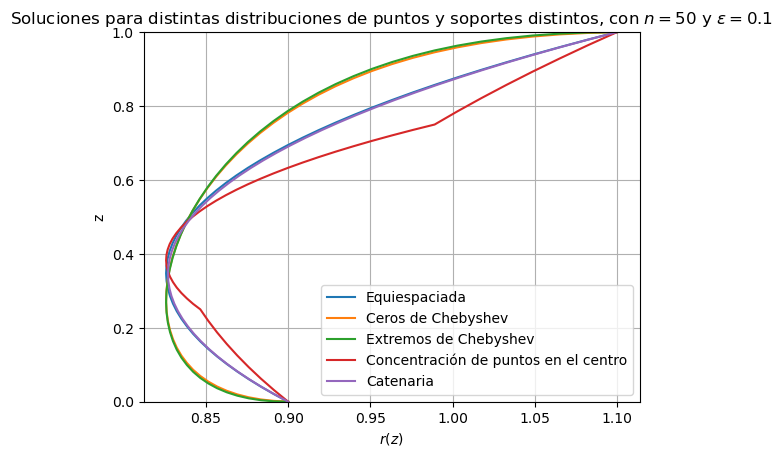

In [ ]:
plt.plot(Famp_eq, zeq, label = 'Equiespaciada')
plt.plot(Famp_chebz, zchebz, label = 'Ceros de Chebyshev')
plt.plot(Famp_chebe, zchebe, label = 'Extremos de Chebyshev')
plt.plot(Famp_cent, zcent, label='Concentración de puntos en el centro')
plt.plot(F_cateq, zeq, label='Catenaria')
plt.ylabel('z')
plt.xlabel('$r(z)$')
plt.ylim(0, 1)
# plt.xlim(0, 1.3)
plt.title('Soluciones para distintas distribuciones de puntos y soportes distintos, con $n = {}$ y $\epsilon = {}$'.format(n, eps))
plt.legend()
plt.grid(True)
plt.show()

### Minimización con un método heurístico (algoritmo genético)

In [ ]:
F_0 = 1
eps = 0.05
F0 = F_0 - eps
F1 = F_0 + eps

n = 20
z = np.linspace(0, 1, n)

bounds = [(F_0-0.5, F_0+0.5) for _ in range(n-2)]

sol_sop = differential_evolution(
    area_func, 
    bounds=bounds, 
    maxiter=100000, 
    popsize=4*n, 
    mutation=(0.5, 1), 
    recombination=0.7, 
    strategy='best1bin', 
    tol=0.001, 
    callback=logger
)

Iteración: 1, Valor de la función: 1.1146585726468887
Iteración: 2, Valor de la función: 1.1107740863260545
Iteración: 3, Valor de la función: 1.0174566855697469
Iteración: 4, Valor de la función: 1.0050269005935595
Iteración: 5, Valor de la función: 1.0050269005935595
Iteración: 6, Valor de la función: 1.0050269005935595
Iteración: 7, Valor de la función: 0.9953879948575456
Iteración: 8, Valor de la función: 0.9923263190612421
Iteración: 9, Valor de la función: 0.9923263190612421
Iteración: 10, Valor de la función: 0.9904907035277162
Iteración: 11, Valor de la función: 0.9651214840700761
Iteración: 12, Valor de la función: 0.9651214840700761
Iteración: 13, Valor de la función: 0.9651214840700761
Iteración: 14, Valor de la función: 0.9651214840700761
Iteración: 15, Valor de la función: 0.9651214840700761
Iteración: 16, Valor de la función: 0.9651214840700761
Iteración: 17, Valor de la función: 0.9637167221917389
Iteración: 18, Valor de la función: 0.9637167221917389
Iteración: 19, Valo

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ismag\AppData\Local\Temp\ipykernel_7032\2438696008.py:14: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Curva optimizada con soportes de diferente tamaño, para $ \epsilon = {}$'.format(eps))


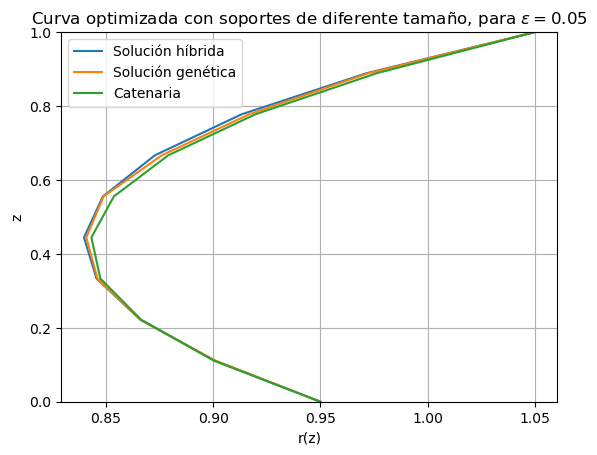

In [ ]:
F_hib_sop = np.concatenate([[F0], sol_sop.x, [F1]]) 
F_ga_sop = np.concatenate([[F0], sol_sop.population[0], [F1]])

a_sol, k_sol = fsolve(params_catenaria, initial_guess)
F_cat = catenaria(z)

plt.plot(F_hib_sop, z, label='Solución híbrida')
plt.plot(F_ga_sop, z, label='Solución genética')
plt.plot(F_cat, z, label='Catenaria')
plt.legend()
plt.xlabel('r(z)')
plt.ylabel('z')
plt.ylim(0, 1)
plt.title('Curva optimizada con soportes de diferente tamaño, para $ \epsilon = {}$'.format(eps))
plt.grid(True)
plt.show()

## Problema con restricciones de volumen, con soportes de diferente tamaño. <font color='red'> QUITAR ESTE APARTADO </font>

A mayores de la condición de que los soportes sean desiguales, se pasa a estudiar el efecto combinado de esta junto con la restricción de volmen.

In [ ]:
F_0 = 1
F0 = F_0
F1 = F_0
n = 50
F_init = np.empty(n-2)
F_init.fill(F_0)
lb = np.zeros(n-2)
ub = np.ones(n-2) * np.inf
bounds = np.vstack((lb, ub)).T

z = np.linspace(0, 1, n)

sol_grad = minimize(area_func, F_init, bounds=bounds, method='SLSQP')
Famp_grad = np.concatenate(([F0], sol_grad.x, [F1]))

In [ ]:
eps = 0.05
F0 = F_0 - eps
F1 = F_0 + eps

sol_grad_voleps = minimize(area_func, F_init, method='SLSQP', bounds=bounds)
Famp_voleps = np.concatenate(([F0], sol_grad_voleps.x, [F1]))

A fin de que los valores no difieran en exceso del valor obtenido del problema sin restricciones, primero se calcula el volumen de la solución con $F_0 = 1$, con la que se partirá para calcular la solución con restricciones.

In [ ]:
V_lig = 0.0 # la ligadura de volumen

vol_eps = vol_func(sol_grad_voleps.x)
print('Volumen sin restricciones =', vol_eps)

Volumen sin restricciones = 0.8047913386876858


Así, se impone la mencionada restricción para observar su influencia en la solución del problema.

In [ ]:
cons = ({'type': 'eq', 'fun': vol_func})

In [ ]:
V_lig = 0.5 # inestable

sol_grad_vol05 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol05 = np.concatenate(([F0], sol_grad_vol05.x, [F1]))

In [ ]:
V_lig = 1

sol_grad_vol1 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol1 = np.concatenate(([F0], sol_grad_vol1.x, [F1]))

In [ ]:
V_lig = 1.5

sol_grad_vol15 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol15 = np.concatenate(([F0], sol_grad_vol15.x, [F1]))

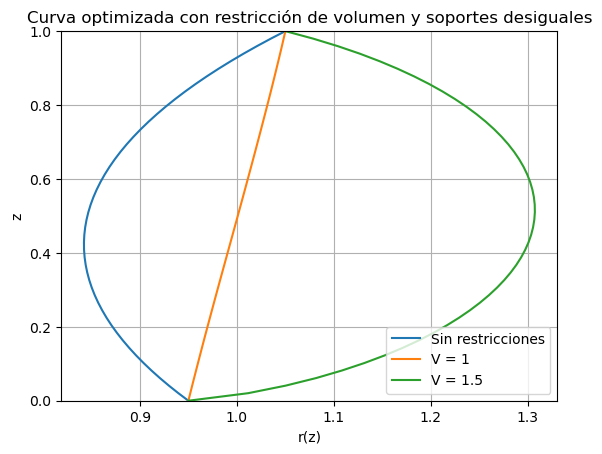

In [ ]:
plt.plot(Famp_voleps, z, label='Sin restricciones')
plt.plot(Famp_vol1, z, label='V = 1')
plt.plot(Famp_vol15, z, label='V = 1.5')
plt.legend()
plt.xlabel('r(z)')
plt.ylabel('z')
plt.ylim(0, 1)
plt.title('Curva optimizada con restricción de volumen y soportes desiguales')
plt.grid(True)
plt.show()


Como cabía de esperar, la forma de la solución se modifica al aumentar el valor de la restricción de volumen. Es importante recalcar que esta restricción no puede tomar cualquier valor, ya que si difiere en gran medida del volumen obtenido sin restricciones, la solución puede resultar inexistente o inestable. 

Precisamente, sobre esas posibilidades se va a discutir a continuación. 

In [ ]:
V_lig = 2

sol_grad_vol2 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol2 = np.concatenate(([F0], sol_grad_vol2.x, [F1]))

In [ ]:
V_lig = 0.4

sol_grad_vol04 = minimize(area_func, F_init, constraints=cons, method='SLSQP', bounds=bounds)
Famp_vol04 = np.concatenate(([F0], sol_grad_vol04.x, [F1]))

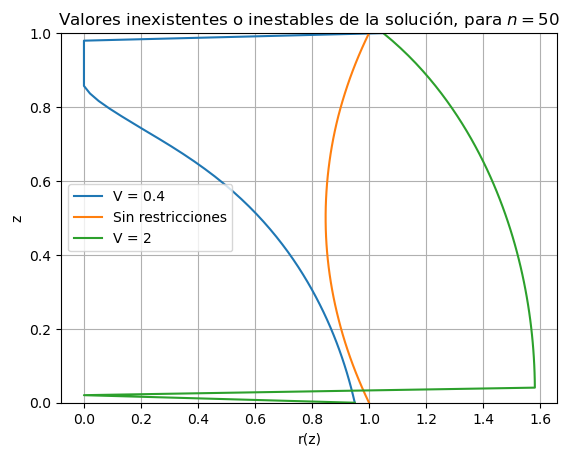

In [ ]:
plt.plot(Famp_vol04, z, label='V = 0.4')
plt.plot(Famp_grad, z, label='Sin restricciones')
plt.plot(Famp_vol2, z, label='V = 2')
plt.legend()
plt.xlabel('r(z)')
plt.ylabel('z')
plt.ylim(0, 1)
plt.title('Valores inexistentes o inestables de la solución, para $n = {}$'.format(n))
plt.grid(True)
plt.show()

Se aprecia que, para valores que se alejan en gran medida de la solución sin restricciones, se generan soluciones que, como poco, no tienen sentido físico. 

Cabe pensar que, para los casos más sensibles, pueda existir solución solo que el método no tiene la precisión adecuada para calcularlo. Así, se plantea evaluar el efecto de aumentar el número de puntos, a fin de tener una representación más precisa, caso que se expone a continuación.

# <font color='red'>**Aspectos a considerar para implementar al problema.**</font>

- Hay que considerar un algoritmo híbrido.

- Considerar arrancar el algoritmo genético en etapas.

- Considerar arrancar el método gradiente en la solución.

- Considerar las restricciones de volumen como el volumen de la solución analítica.

- Revisar que todos los errores sean el Error Cuadrático Medio y no el absoluto.

- Revisar el texto de los apartados de con restricciones.

- Comparar errores de los algoritmos genéticos con los de los gradiente

- Subir a Github para referenciarlo en la bibliografía

- Incluir las especificaciones del ordenador con las que se corre.

- Cambiar los gráficos a F(z)